In [6]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools
import os
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import requests
from itertools import combinations
from sklearn import linear_model, ensemble
from statsmodels.api import OLS 
import sklearn.metrics as metrics
import time
import ipynb.fs.full.source_library as lib

from datetime import datetime, timedelta

quandl.ApiConfig.api_key = HIDDEN
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)

Zachary Mariani 
Student ID # 12188511

# 1. Motivation and Introduction  

## 1.1 Relationships 

### 1.1.1 Relationship Between Oil and Currencies
I began this final project with the hypothesis that there might be some leading-lagging relationship between crude oil (and accordingly its near term futures) and currencies for countries which heavily import and export oil. At the most basic level, let's say an oil exporter like Canada relies a great deal on its oil exports to sustain its economy. Most of the international demand for that local currency Canadian Dollar (colloquially the loonie) therefore is driven by demand for oil. Oil importer countries such as South Korea will then need to sell their currencies in order to buy the Canadian oil in loonies. As such, the South Korean won will depreciate in value relative to the loonie. If oil prices move up, South Koreans will have to buy even more loonies, so, the Won will depreciate even further and vice versa - oil prices might lead currencies. 

### 1.1.2 Relationship with Weather 
To take it one step further, in years where the population in oil importing countries lives in very cold weather (a particularly bad or long winter), it might be the case that South Koreans have to buy more oil than is usual, and thus this effect is amplified. Potentially, weather might leader oil prices which could then in turn lead currencies. 

## 1.2 Early Strategy Design 

As such, I hope to design a strategy which takes in weather data, uses it to predict oil movements and then currency movements. Given that weather patterns and currency movements happen very slowly, I hope to have a longer time period spanning at least one decade maybe ever further given the availability of the data. After forming this hypothesis, I explored the academic literature (described in further detail below). 

# 2 Academic Literature 

## 2.1 Literature Review

The two papers I found which cover this hypothesis and the related topics are:

1. [Oil Prices and Market Exchange Rates (2013)](https://www.jstor.org/stable/pdf/23437709.pdf?ab_segments=0%2Fbasic_search_gsv2%2Fcontrol&refreqid=fastly-default%3Aee7b133f612dd8adcf64172742a28e82) by Turhan, Hacihasanoglu, and Soytas researchers at the Istanbul Stock Exchange explores the relationship between emerging market exchange rates (not only EMs related to oil, but also Argentina, Poland, Turkey, etc.) and oil prices. They use daily data from January 2003 until June 2010 and conclude that *a rise in oil prices leads to significant appreciation of emerging economies' currencies against the US dollar*. They also find that throughout the period this effect changes pre and post 2008, with a stronger relationship present after 2008 which they attribute to policy changes by OPEC post 2008. 

2. [Can Exchange Rates Forecast Commodity Prices? (2010)](https://www.jstor.org/stable/pdf/27867508.pdf?ab_segments=0%2Fbasic_search_gsv2%2Fcontrol&refreqid=fastly-default%3Aee7b133f612dd8adcf64172742a28e82) by Chen, Rogoff, and Rossi researchers at MIT and Harvard explore the relationship between commodity prices and exchange rates for commodity currencies, not restricted to oil, such as (CAD, NZD, AUD). Using quarterly data from 1989 to 2008, an they conclude that *commodity currency exchange rates have surprisingly robust power in predicting global commodity prices ... we also explore the reverse relationship but find it to be notably less robust.* They offer the intuitive explanation that exchange rates are strongly forward-looking, whereas commodity price fluctuations are typically more sensitive to short-term demand imbalances. They find that their results are robust to multivariate regressions, choice of the numeraire currency, forecast combinations, high persistent regressors, and longer-horizon predictions. 

# 3 Defining the Universe

## 3.1 Further Strategy Design

After reading the literature, I've decided to explore the lag/lead dynamic between oil prices and currencies. I think that adding data about the weather could be a very useful, relevant, and insightful instrumental variable in the case which contradicts Rogoff's findings. I also think it might be interesting to try to account for differences in oil import and export levels over time.

## 3.2 Assets of Relevance

### 3.2.1 Discussion of Currencies 

Given that many of the OPEC countries have opted to use fixed / quasi-fixed exchange rates, we will exclude them from our research and strategy. If they were included, the strategy's performance could vary with policy changes which is not an aim. 

Further, after reading the academic literature, it is clear that there can be a variety of factors at play which might affect the seasonal, periodic, or otherwise "regime-change" performance of this strategy. In order to account for this, I am going to attempt to weight the different currencies in my strategy by the exposure that each one has to oil. The only time series data I was able to find about different countries level of exposure to oil was the World Bank's Fuel Exports (as a percent of merchandise exports) and Fuel imports (as a percent of merchandise imports). Furthermore, I have decided against including the USD as a currency we will use to speculate given that the US is exposed on both sides as both a large importer and exporter. Based on the availability of data, we will focus on the following currencies: 

Export: Australia, Brazil, Canada, Colombia, Norway, and Mexico

Import: Japan, South Korea, Euro area 

### 3.2.2 Discussion of Oil Futures 

We will use Quandl's Continuous Futures database which automatically rolls our crude oil futures contracts one month forward on the last day. NB: This might be subject to backwardation and contango, but is the best, most realistic measure that we have. 

# 4 Gathering Data

We are going to attempt to get weekly data from 2000 to 2020. 

In [10]:
start_date = '2000-01-01'
end_date = ' 2020-12-31'

## 4.1 Currency Data (import_df, export_df)

The currency rate data itself comes from Quandl's [CUR/](https://www.quandl.com/data/CUR-Foreign-Exchange-Rates) database.

In [11]:
#get the list of import currencies  
import_lst = ['AUD', 'BRL', 'CAD', 'COP', 'NOK', 'MXN']
import_df = pd.DataFrame()

#get their rates, 1/cur
for cur in import_lst:
    temp_df = quandl.get('CUR/'+cur, start_date=start_date, end_date=end_date)
    import_df[cur] = temp_df['RATE']

In [12]:
#get the list of export currencies 
export_lst = ['JPY', 'KRW', 'EUR']
export_df = pd.DataFrame()

#get their rates, 1/cur
for cur in export_lst: 
    temp_df = quandl.get('CUR/'+cur, start_date=start_date, end_date=end_date)
    export_df[cur] = temp_df['RATE']

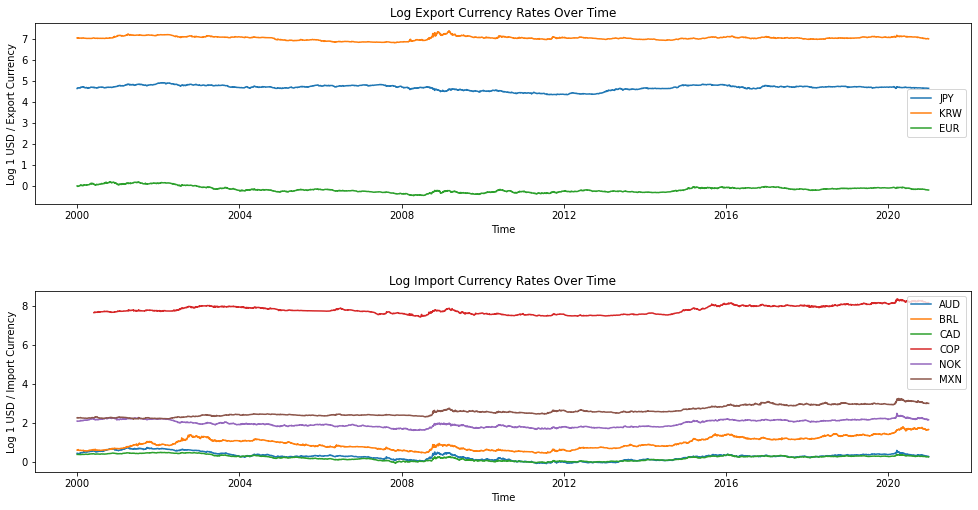

In [13]:
fig, ax = plt.subplots(2,1, figsize = (14.5, 8))

for country in export_df.columns:
    ax[0].plot(np.log(export_df[country]), label = country)
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Log 1 USD / Export Currency')
ax[0].set_title('Log Export Currency Rates Over Time')

for country in import_df.columns: 
    ax[1].plot(np.log(import_df[country]), label = country)
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Log 1 USD / Import Currency')
ax[1].set_title('Log Import Currency Rates Over Time');

fig.tight_layout(pad = 4.0)

## 4.2 Fuel Import / Export Data (import_wb, export_wb)

The data on fuel import/export as a percentage of total merchandise [import](https://data.worldbank.org/indicator/TM.VAL.FUEL.ZS.UN)/[exports](https://data.worldbank.org/indicator/TX.VAL.FUEL.ZS.UN) come from the [World Bank](https://www.worldbank.org/en/home). Of course, *fuel* broadly contains more than just crude oil, but this was the best and most thorough dataset I could find. As such, we will take *fuel* as a fair proxy for crude oil.

In [14]:
#bring in the time series data on fuel import/export as a percent of total
#merchandise import/export
#we will use this later when dynamically weighting our strategy 
import_wb = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Imports.csv')
export_wb = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Exports.csv')

#clean it a bit 
yrs = [str(y) for y in range(2000, 2021)]
yrs.insert(0, 'Country Name')

import_wb = import_wb[yrs]
import_wb.set_index('Country Name', inplace=True)

export_wb = export_wb[yrs]
export_wb.set_index('Country Name', inplace=True)

#filter to only countries of interest 
import_country_name = ['Japan', 'Korea, Rep.', 'Euro area']
import_wb = import_wb[import_wb.index.isin(import_country_name)]

export_country_name = ['Australia', 'Brazil', 'Canada',\
                       'Colombia', 'Norway', 'Mexico', 'Egypt']
export_wb = export_wb[export_wb.index.isin(export_country_name)]

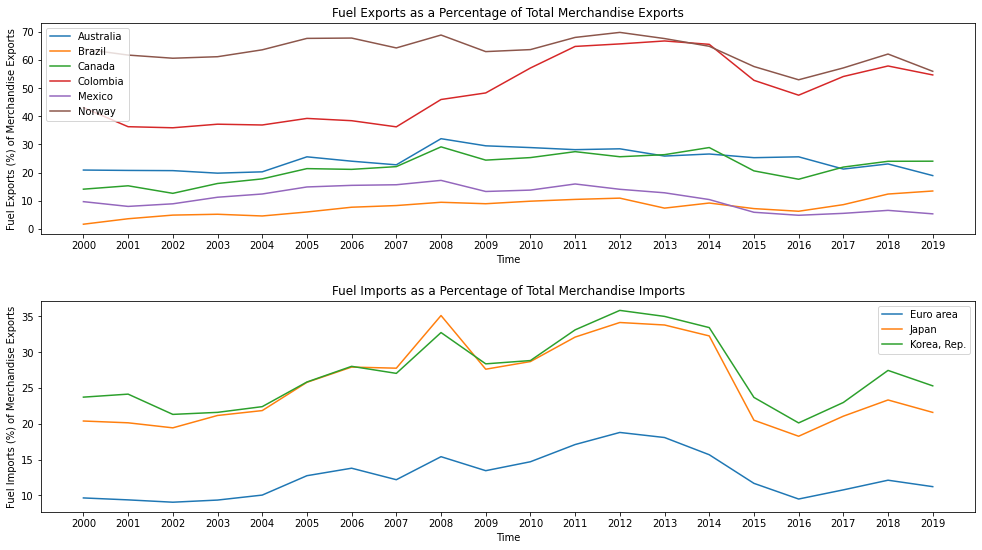

In [15]:
fig, ax = plt.subplots(2,1, figsize = (14, 8))
for country in export_wb.index:
    ax[0].plot(export_wb.loc[country], label = country)
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Fuel Exports (%) of Merchandise Exports')
ax[0].set_title('Fuel Exports as a Percentage of Total Merchandise Exports')

for country in import_wb.index:
    ax[1].plot(import_wb.loc[country], label = country)
ax[1].legend()
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Fuel Imports (%) of Merchandise Exports')
ax[1].set_title('Fuel Imports as a Percentage of Total Merchandise Imports')

fig.tight_layout(pad = 2.0)

To give this some further intuition, Norway has much more of its exports in oil than Brazil so we might expect Norway's currency's relationship to oils to be stronger than Brazil's. 

## 4.3 Oil Futures Data (contin_futures)

Unfortunately, when I was originally planning this project, I was planning on using Quandl's amazing database for one month continuous forward futures prices. Sadly, it is behind a pay-wall. Therefore, I had to use data from [MarketWatch](https://www.marketwatch.com/investing/future/cl00/download-data?startDate=1/1/2008&endDate=12/31/2008) which only goes back to 2009, but at the very least is daily. Further, this data is for the contract which ends less than 1 month from now, is a continuous time series, is daily, and goes back as early as 2009. The contains open, high, low, and close prices, and in order to make this even more realistic, we will use the average of the open and close prices as the contract price that we might have traded on any particular day (trading at the close with high volume is potentially not plausible, trading midday might have lower volumes, but we'll just assume we would get closer to the midpoint of the day's price than the close of the day). 

The continuous contract is for the NYMEX WTI Crude Oil. There were obviously many choices for which crude oil contract I could've used, I used this because it already had the best continuous data available. 

I could have also constructed my own continuous futures. However, I was afraid that this could introduce too much room for error. 

In [16]:
contin_futures = pd.DataFrame()
for file in os.listdir('/Users/zachmariani/FINM/Final Project/Data/Continuous Futures'):
    if file[-3:] == 'csv':
        temp = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Continuous Futures/' + file)
        contin_futures = contin_futures.append(temp)
contin_futures['Date'] = pd.to_datetime(contin_futures['Date'], format = '%m/%d/%Y')

contin_futures.set_index('Date', inplace = True)

contin_futures.sort_index()

contin_futures['Price'] = (contin_futures['Open'] + contin_futures['Close'])/2
contin_futures['Price'] = round(contin_futures['Price'], 2)
contin_futures = contin_futures.sort_values('Date')

In [17]:
contin_futures.head()

,Open,High,Low,Close,Price
Date,,,,,
2009-04-24,49.65,51.75,49.06,51.55,50.60
2009-04-27,51.45,51.45,48.01,50.14,50.80
2009-04-28,50.10,50.19,48.55,49.92,50.01
2009-04-29,49.25,51.42,49.12,50.97,50.11
2009-04-30,50.79,51.94,50.21,51.12,50.96


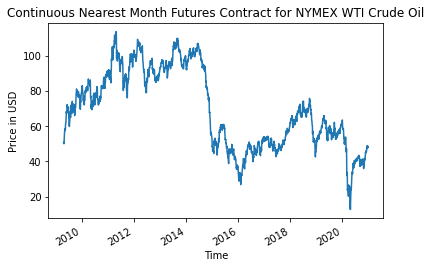

In [18]:
contin_futures['Price'].plot()
plt.title('Continuous Nearest Month Futures Contract for NYMEX WTI Crude Oil')
plt.xlabel('Time')
plt.ylabel('Price in USD');

## 4.4 Weather Data (clean_weather)

In order to keep the analysis relatively clean and simple, we are only going to get weather data for the three largest cities in import countries (Japan, South Korea, and the Euro area). I postulate that the weather in the major exporters will not have a large effect in the dynamics in this market. I will use the three largest cities (measured by population) from each of these three areas (Tokyo, Yokohama, Osaka), (Seoul, Busan, Incheon), and (Berlin, Madrid, and Paris).

All of my weather data is sourced from [NOAA](https://www.ncdc.noaa.gov/cdo-web/search)

In [19]:
SK_weather = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/South Korea.csv')
#filter to only cities of interest 
SK_cities_of_interest = \
    ['SEOUL CITY, KS', 'INCHEON, KS', 'BUSAN, KS']
bool_SK = SK_weather['NAME'].isin(SK_cities_of_interest)
SK_weather = SK_weather[bool_SK]

#convert index to timeseries
SK_weather['DATE'] = pd.to_datetime(SK_weather['DATE'], format = '%Y-%m-%d')
SK_weather.set_index('DATE', inplace = True)

#fill any missing TAVG data with the average of the daily high and low
SK_weather['TAVG'].fillna((SK_weather['TMAX'] + SK_weather['TMIN'])/2, inplace = True)

In [20]:
#put European Data Together! 
Euro_Weather = pd.DataFrame()
berlin = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/Berlin.csv')
paris = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/Paris.csv')
madrid = pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/Madrid.csv')
Euro_Weather = Euro_Weather.append(berlin)
Euro_Weather = Euro_Weather.append(paris)
Euro_Weather = Euro_Weather.append(madrid)

#convert index to timeseries
Euro_Weather['DATE'] = pd.to_datetime(Euro_Weather['DATE'], format = '%Y-%m-%d')
Euro_Weather.set_index('DATE', inplace = True)

#fill any missing TAVG data with the average of the daily high and low
Euro_Weather['TAVG'].fillna((Euro_Weather['TMAX'] + Euro_Weather['TMIN'])/2, inplace = True)

In [21]:
#merge all Japanese data together
Japan_Weather = pd.DataFrame()
Japan_Weather = Japan_Weather.append\
    (pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/Japan 2008-2012.csv'))
Japan_Weather = Japan_Weather.append\
    (pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/Japan 2012-2016.csv'))
Japan_Weather = Japan_Weather.append\
    (pd.read_csv('/Users/zachmariani/FINM/Final Project/Data/Weather/Japan 2016-2020.csv'))

#filter to only cities of interest
Japan_cities_of_interest = \
    ['TOKYO, JA', 'YOKOHAMA, JA', 'OSAKA, JA']
Japan_Weather = Japan_Weather[Japan_Weather['NAME'].isin(Japan_cities_of_interest)]

#convert index to timeseries
Japan_Weather['DATE'] = pd.to_datetime(Japan_Weather['DATE'], format = '%Y-%m-%d')
Japan_Weather.set_index('DATE', inplace = True)

#fill any missing TAVG data with the average of the daily high and low
Japan_Weather['TAVG'].fillna((Japan_Weather['TMAX'] + Japan_Weather['TMIN'])/2, inplace = True)

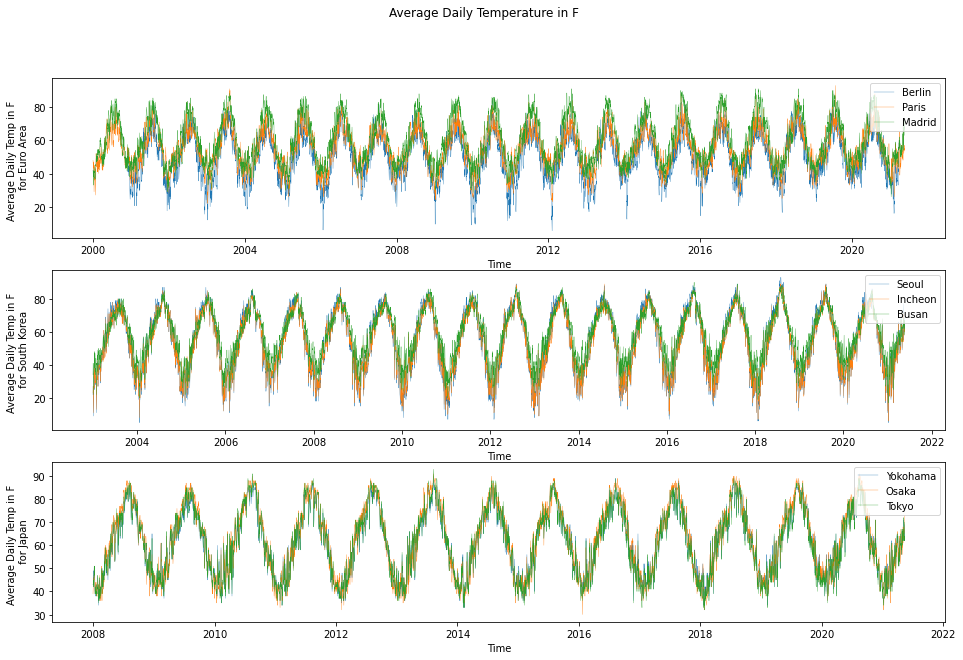

In [22]:
#plot the three cities in each of the three countries 
fig, ax = plt.subplots(3,1, figsize = (16, 10))

weather = {
        'Euro Area': Euro_Weather, 
        'South Korea': SK_weather,
        'Japan' :Japan_Weather
           
          }
fig.suptitle('Average Daily Temperature in F')
p_count = 0
for area, data in weather.items():
    for city in data['NAME'].unique():
        ax[p_count].plot(data[data['NAME'] == city]['TAVG'], \
                         label = city.split(',')[0].capitalize().split(' ')[0], linewidth=0.33)
    
    ax[p_count].legend(loc='upper right')
    ax[p_count].set_ylabel('Average Daily Temp in F \n for ' + area)
    ax[p_count].set_xlabel('Time')
    p_count+=1
    

Since this data is by city and not by country (which we need for currencies), we'll have to convert it to by country. I have used population and GDP/cap in each city to weight the importance of the city to the entire country's oil demand.

NB: in retrospect (typing this after finishing the strategy) this was a poor decision. By ultimately using RF, I unnecessarily reduced potential features. ML would have been better at feature selection than this justification, however, given that I wanted this notebook to cleanly represent the workflow of the project, I kept this as it is. I ran a version of the strategy using all weather data in a different notebook after the fact and found no meaningful differences. I did not include that for concision.

In [23]:
#the weights here give (pop, GDP/cap) at the most recent figures I could find 
#oil consumers are people and people with higher spending potential (measured by GDP/cap)
#are likely to spend more anyways, demand oil is not a perfectly elastic nonetheless we will use 
#these figures to discount and generate a "country temperature"
Japan_weights = {
    'TOKYO, JA': (14000000, 69000),
    'YOKOHAMA, JA' : (3725000 , 31000), 
    'OSAKA, JA' : (2691000,  41660)
}

SK_weights = {
    'SEOUL CITY, KS' : (9770000, 39000), 
    'INCHEON, KS' : (2923000, 30500),
    'BUSAN, KS' : (3500000, 22000)
}

Euro_weights = {
    'BERLIN DAHLEM, GM' : (3645000, 49500), 
    'PARIS LE BOURGET, FR': (2100000, 65700),
    'MADRID RETIRO, SP': (3250000, 40000)
}

weather_city_weights ={
    'Euro Area': Euro_weights,
    'South Korea': SK_weights, 
    'Japan': Japan_weights
}

#a place to store the individual city weights 
factor_weights  = {}

for area, a_data in weather_city_weights.items():
    a_factor = 0
    
    #loop through and get the total factor across the population 
    for city, c_data in a_data.items(): 
        c_factor = c_data[0] * c_data[1]
        a_factor += c_factor
    for city, c_data in a_data.items(): 
        c_factor = c_data[0] * c_data[1]
        factor_weights[city] = c_factor / a_factor 
        
#we see that the European cities are much more balanced which makes sense because they all have roughly 
#the same population and GDP / cap
#Tokyo has almost all of the weighting for Japan which makes sense given it is so mucy larger 
#than the two next largest cities 
factor_weights

{'BERLIN DAHLEM, GM': 0.4023829303240986,
 'PARIS LE BOURGET, FR': 0.3076957387139759,
 'MADRID RETIRO, SP': 0.2899213309619255,
 'SEOUL CITY, KS': 0.6963502969307259,
 'INCHEON, KS': 0.1629285712327628,
 'BUSAN, KS': 0.14072113183651128,
 'TOKYO, JA': 0.8093285182252152,
 'YOKOHAMA, JA': 0.09674659486755356,
 'OSAKA, JA': 0.09392488690723116}

In [24]:
clean_weather = {}
#get the weighted averages from each city to build country time series
for area, data in weather.items(): 
    area_df = pd.Series()
    for city in data['NAME'].unique(): 
        city_df = data[data['NAME'] == city]
        city_df = city_df[['TAVG', 'PRCP']]
        city_df = city_df * factor_weights[city]
        try: 
            area_df['TAVG'] += city_df['TAVG']
        except: 
            area_df['TAVG'] = city_df['TAVG']
        try: 
            area_df['PRCP'] += city_df['PRCP']
        except: 
            area_df['PRCP'] = city_df['PRCP']
    area_df = area_df
    clean_weather[area] = area_df 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


A couple of remarks on the weather data: we have that in Japan and South Korea, the weather data in the three largest cities is very similar. It is clear that there are some years when the temperature is much colder or hotter than in past years - this is exactly what we're hoping to use to predict future oil price movements. Further, we see that in the Euro area, Berlin is significantly colder than Madrid and Paris. We are going to use an average that is weighted by population in each city times GDP per capita of the city. This helps account for the different purchasing powers and population effects of each city. We will just use the most recent measures and not worry about time factors, for simplicity's sake. 

We now see below that we have one trendline per country (instead of three cities).

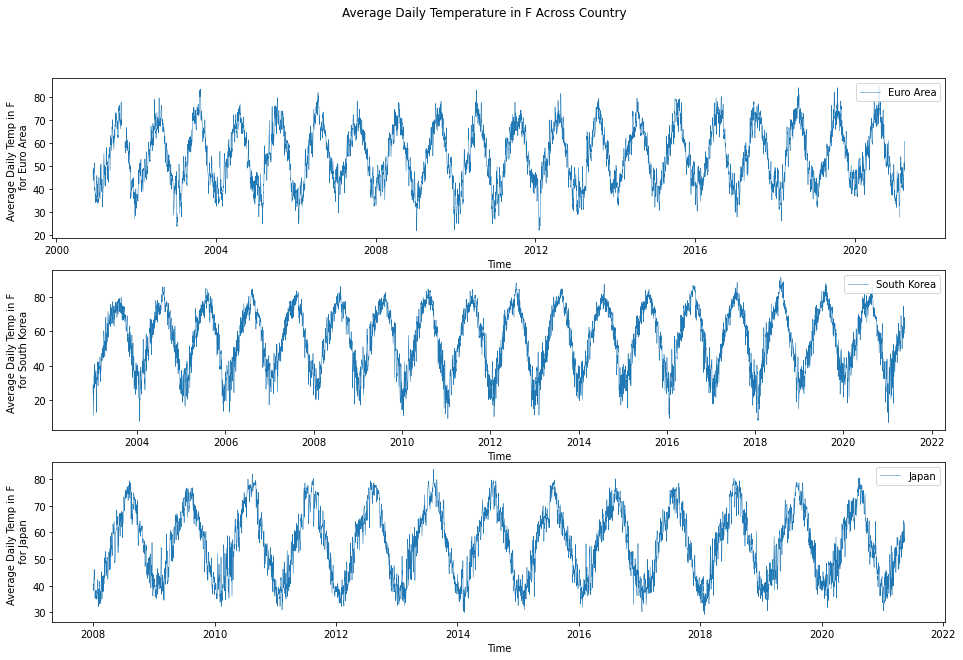

In [25]:
#plot the factored country average daily temperature
fig, ax = plt.subplots(3,1, figsize = (16, 10))

fig.suptitle('Average Daily Temperature in F Across Country')
p_count = 0
for area, data in clean_weather.items():
    ax[p_count].plot(data['TAVG'], label = area, linewidth=0.5)
    
    ax[p_count].legend(loc='upper right')
    ax[p_count].set_ylabel('Average Daily Temp in F \n for ' + area)
    ax[p_count].set_xlabel('Time')
    p_count+=1
        

In [26]:
#make it easier to use this data later!
copy = clean_weather.copy()
clean_weather = pd.DataFrame()
for country, both_data in copy.items(): 
    for spec_data in both_data:
        temp_df = pd.DataFrame(spec_data)
        temp_df.rename(columns = {spec_data.name : country + '_'+  spec_data.name}, inplace=True)
        clean_weather = clean_weather.join( temp_df, how = 'outer') 

clean_weather = clean_weather[~clean_weather.index.duplicated(keep = 'first')]

Now, what we are really interested in is the change in weather from the year before. I would prefer to use how the weather compares to maybe the last three winters or some memory, but if I did that, it would reduce the total amount of backtesting that would be possible. Therefore, I am just comparing the weather data each day to the weather data the year before. This only shrinks the dataset by one year instead of multiple. 

In [27]:
clean_weather.head()

,Euro Area_TAVG,Euro Area_PRCP,South Korea_TAVG,South Korea_PRCP,Japan_TAVG,Japan_PRCP
DATE,,,,,,
2000-12-01,48.061993,0.139285,NaN,NaN,NaN,NaN
2000-12-02,47.615294,0.148463,NaN,NaN,NaN,NaN
2000-12-03,43.683439,0.002899,NaN,NaN,NaN,NaN
2000-12-04,45.455466,0.009231,NaN,NaN,NaN,NaN
2000-12-05,46.783986,0.148926,NaN,NaN,NaN,NaN


In [28]:
delta_weather = clean_weather.copy()

for date in clean_weather.index: 
    
    past_date = date - relativedelta(years=1)
    
    if past_date not in clean_weather.index: 
        delta_weather.loc[date] = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
        
    else: 
        past_data = clean_weather.loc[past_date].values
        current_data = clean_weather.loc[date].values
        
        difference = current_data - past_data 
        
        delta_weather.loc[date] = difference 

In [29]:
d_rename = {}
country_rename = {
    'Euro Area' : 'EUR', 
    'South Korea' : 'KRW', 
    'Japan': 'JPY'
}

for col_name in delta_weather.columns:
    country, ptype = col_name.split('_')
    country_code = country_rename[country]
    d_rename[col_name] = ptype.lower() + '_delta_' + country_code 

delta_weather.rename(columns = d_rename, inplace=True)

# 5 Constructing Theoretical Model 

## 5.1 Model Overview 

Now that we have gathered and cleaned all of our data, we will attempt to define a model which shows the relationship between oil import/export, weather, and oil futures. From there, we will build the backtest.

Let us also recall the two relationships of interest between the data sets: 

1. Colder temperatures in the import countries imply that there will be greater demand for oil in the future, warmer temperatures in the import countries imply that there will be less demand for oil in the future

2. The import currencies falling and export currencies rising should predict a rise in oil prices, the import currencies rising and the export currencies falling should predict a fall in oil prices

Then, let us define a couple of variables to use in our model:


1. $n$ is time period, 
2. $t_d$ is the time delay between oil futures price movements and leading currency indicator
2. $C$ is country, 
3. $I = \{South Korea, Japan, and Eurozone\} $ the set of the import countries,
4. $E =\{Australia, Brazil, Canada, Colombia, Norway, Mexico, Egypt\}$ is the set of the export countries 
5. $temp(n, C)$ is the temperature's effect on oil prices, 
6. $imp(n, C)$ is the effect of the import currency on the oil price, 
7. $exp(n, C)$ is the effect of the export currency on the oil price, and 
8. $\Omega(n, C)$ is the weighting of the importance of oil as an import/export from the World Bank database. 
9. $\alpha$ is our model's constant 
10. $\epsilon$ is our white noise error term


Our model will be roughly of the form:

$$Oil_{n+t_d} = \alpha + \sum_{C \in I} temp(n, C) + \sum_{C \in I} imp(n, C) * \Omega(n,C) + \sum_{C \in E} exp(n, C) * \Omega (n,C) + \epsilon $$

Oil futures next week are some function of the constant + the temperature effects + the import currency effects weighted by importance + the export currency effects weighted by their importance + some error term

## 5.2 Potential Models 

In essence, our game plan is to build some predictive model, we're going to experiment with (i) simple OLS, then (ii) a lasso model, and then (iii) a random forest. Once we have decided which of these three models seems best suited to our needs for this trading algorithm, we will go into the backtesting phase of development. 

## 5.3 Parameters to Optimize

NB: apart from the obvious 3 potential models to choose from, we will have a variety of parameters to optimize. $t_d$ is the most important parameter, however, as we proceed, undoubtedly more will arise. 


# 6 Constructing Practical Models 

## 6.1 Methodology 

Once we have developed the theoretical model, we are going to play around with a couple of practical models and different ways to implement it. Once we have found one that we like and works well, we will then design the backtest. 


For simplicity, we are only going to be using monthly changes, I originally considered weekly, but ruled it out due to computational complexity and the fact that these changes likely happen slowly. I don't think looking at the weekly weather changes will be as predictive as the monthly changes. 


I also am going to only test the model's ability to predict one month forward returns. In theory, the delay between currency/weather moves and oil moves might take place over a variety of different time periods, from hours to several months. I think though for this project, it makes the most sense to just test one month ahead given the data we currently have and the lead-lag time horizon that I am hypothesizing. If I were to do this in industry, I would of course devote more time to optimizing these parameters.


Therefore, in this next section, we are going to only experiment with the methodology for calculating the relationship and the variable sets that we can use. The variable sets are the possible combinations of data sources (i.e. currency prices alone, currency prices and contemporaneous weather, etc.) and the methodologies for calculating the relationship we will limit to OLS with exponential time-decaying weighting, a Lasso model, and then a very basic ML Random Forest (RF) model from SKLearn's library. 


Although this is another parameter that we could choose to attempt to optimize, we are going to use a look back period of 12 months (i.e. one year) as the data we feed into weighted OLS, Lasso, or RF. I have chosen 12 months given that using a larger period of time will reduce the total potential trades we could make, and the fact that I think 12 months is an adequate period of data on which to draw to uncover these relationships. 


## 6.2 Constructing Monthly Data Panel

In [30]:
#get the monthly trading days, we'll just use the first trading day of the month 
monthly_panel = \
    lib.build_monthly_panel(contin_futures, import_wb, export_wb, clean_weather, delta_weather)


In [34]:
#take a look at the monthly panel 

monthly_panel.head()

,USD_AUD,USD_BRL,USD_CAD,USD_COP,USD_NOK,USD_MXN,USD_JPY,USD_KRW,USD_EUR,oil_open,oil_high,oil_low,oil_close,oil_price,temp_EUR,prcp_EUR,temp_KRW,prcp_KRW,temp_JPY,prcp_JPY,tavg_delta_EUR,prcp_delta_EUR,tavg_delta_KRW,prcp_delta_KRW,tavg_delta_JPY,prcp_delta_JPY,imp_AUD,imp_BRL,imp_CAD,imp_COP,imp_EUR,imp_JPY,imp_KRW,imp_MXN,imp_NOK
2009-04-24,1.386615,2.193774,1.212175,2290.179554,6.561238,13.180648,97.024283,1338.781563,0.754414,49.65,51.75,49.06,51.55,50.60,57.854800,0.000000,54.837071,0.0,49.527083,0.000000,1.195234,-0.012071,3.437115,0.0,-5.817154,-0.028177,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585
2009-05-01,1.370334,2.175265,1.185892,2293.473490,6.552357,13.814749,99.123126,1277.347879,0.753666,50.95,53.65,50.43,53.20,52.08,59.130236,0.000000,64.229772,0.0,61.233382,0.000000,4.435024,-0.072191,-2.022207,0.0,-1.806507,0.000000,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585
2009-06-01,1.233977,1.948425,1.086714,2125.685194,6.186465,13.130690,95.951730,1239.248677,0.705118,66.48,68.68,66.23,68.58,67.53,69.017535,0.008048,72.481751,0.0,60.084349,0.428944,2.046886,-0.041239,1.392701,0.0,-1.806507,0.186146,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585
2009-07-01,1.236672,1.936320,1.148587,2151.006942,6.346569,13.121496,96.615947,1269.426059,0.706565,70.45,71.85,68.52,69.31,69.88,76.671383,0.000000,73.229772,0.0,67.310376,0.232748,3.100645,0.000000,-3.014952,0.0,0.997178,0.232748,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585
2009-08-03,1.188467,1.843100,1.067021,2039.038555,6.042042,13.122747,95.168989,1216.918989,0.694787,69.30,72.20,69.09,71.58,70.44,67.360637,0.024143,75.970537,0.0,71.826643,0.129493,-7.076913,0.008758,-0.681398,0.0,-5.137746,0.129493,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585


In [35]:
#we need to compare returns and not changes in prices
#so get the returns

monthly_panel = lib.update_monthly_panel_for_returns(monthly_panel)

In [39]:
#save locally
monthly_panel.to_csv('/Users/zachmariani/FINM/Final Project/Data/Data Saves/monthly_panel.csv')

## 6.3 Testing 

Since we have our monthly panel now, we will begin to run tests with our different parameters sets and model types (Weighted OLS, Lasso, and RF).

While I have gathered four different datasets to use as exogenous variables in the model and we can create a variety of potential combinations, I think it is wise (and computationally efficient) to use only these four combinations: 

1. Currencies alone 
2. Currencies & contemporaneous weather  
3. Currencies & changes in weather 
4. Currencies & contemporaneous weather & changes in weather & importance of oil as an import/export 


NB: I have decided to exclude precipitation data to increase efficiency of the code and because I don't think it will be relevant to oil market movements. I think that only temperature would really drive the differences.

NB: in retrospect (writing this after running the entire algorithm, I might have considered including previous oil returns in the strategy as well). In a different notebook I included last months oil returns to every parameter set and found no meaningful difference. I excluded those tests for concision.

In [36]:
#get all of the variable sets 

cur = []
contemp_weather = []
delta_weather = []
imp = []

for column in monthly_panel.columns:
    if column[0:5] == 'r_USD':
        cur.append(column)
    elif 'tavg_delta' in column:
        delta_weather.append(column)
    elif column.split('_')[0] == 'temp':
        contemp_weather.append(column)
    elif column.split('_')[0] == 'imp': 
        imp.append(column) 

var_sets ={
    'cur' : cur, 
    'contemp_weather' : contemp_weather,
    'delta_weather' : delta_weather, 
    'imp' : imp
}

#create combinations of exogenous variables to test 

combo_0 = var_sets['cur']
combo_1 = var_sets['cur'] + var_sets['contemp_weather']
combo_2 = var_sets['cur'] + var_sets['delta_weather']
combo_3 = var_sets['cur'] + var_sets['delta_weather'] + var_sets['contemp_weather'] + var_sets['imp']

var_combos = [combo_0, combo_1, combo_2, combo_3]

In [217]:
'''
Now that we have set up all of the helper functions above, we are going to go ahead and build the test, 
this cell takes a very long time to run 
'''

#list variables to store all of the information 
r_types_lst = []
var_combos_lst = []
results_lst = []
dates_lst = []

#our sets of combinations 
r_types = ['OLS', 'Lasso', 'RF']
var_combos 
ints = np.arange(0,len(monthly_panel) - 13, 1)

#build a nested loop to run through everything 
for r_type in r_types:
    for n_inputs, inputs in enumerate(var_combos):
        
        time_0 = time.time()
        
        for i_int in ints:
            
            #build the specific panel 
            panel = monthly_panel.iloc[i_int : i_int + 13]
            
            #get the results from the test
            results = lib.run_test(panel, r_type, inputs)
            
            #record everything
            r_types_lst.append(r_type)
            var_combos_lst.append(n_inputs)
            results_lst.append(results)
            dates_lst.append(monthly_panel.index[i_int + 13])
    
        print('Finished input set ', n_inputs, ' r_type ', r_type, ' in ', time.time() - time_0, ' seconds ')

Finished input set  0  r_type  OLS  in  0.6291167736053467  seconds 
Finished input set  1  r_type  OLS  in  0.692439079284668  seconds 
Finished input set  2  r_type  OLS  in  0.6277711391448975  seconds 
Finished input set  3  r_type  OLS  in  0.6237523555755615  seconds 
Finished input set  0  r_type  Lasso  in  0.5491032600402832  seconds 
Finished input set  1  r_type  Lasso  in  0.5467019081115723  seconds 
Finished input set  2  r_type  Lasso  in  0.5475447177886963  seconds 
Finished input set  3  r_type  Lasso  in  0.5708880424499512  seconds 
Finished input set  0  r_type  RF  in  156.23701214790344  seconds 
Finished input set  1  r_type  RF  in  154.79057788848877  seconds 
Finished input set  2  r_type  RF  in  140.80058479309082  seconds 
Finished input set  3  r_type  RF  in  144.60598015785217  seconds 


In [218]:
#create a DF of all of the outcomes data
outcomes = pd.DataFrame({
    'R Type' : r_types_lst, 
    'Var Combo' : var_combos_lst,
    'Result' : results_lst, 
    'Date' : dates_lst
})

#export it to the local drive so that I never have to run it again! 
outcomes.to_csv('/Users/zachmariani/FINM/Final Project/Data/Data Saves/outcomes.csv')


,R Type,Var Combo,Result,Date
0,OLS,0,0.000779,2010-07-01
1,OLS,0,0.042933,2010-08-02
2,OLS,0,0.009451,2010-09-01
3,OLS,0,0.111878,2010-10-01
4,OLS,0,0.008009,2010-11-01


## 6.4 Interpreting Results

We have generated all of our outcomes, now we look to see which regression type and variable combination is the best. Once we have determined what to use, then we will go ahead and build the backtest.

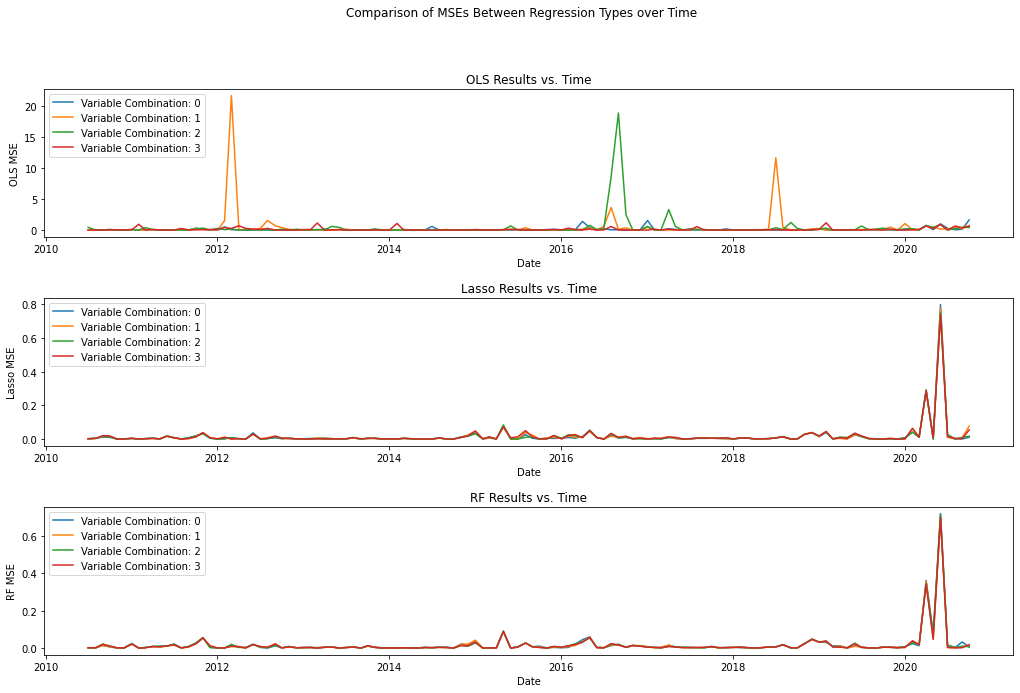

In [219]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize = (15,10))
ax_counter = 0 
fig.suptitle('Comparison of MSEs Between Regression Types over Time')
fig.tight_layout(pad = 4.0)
for r_type in outcomes['R Type'].unique(): 
    unique_df = outcomes.loc[(outcomes['R Type'] == r_type)]
    
    for var_combo in unique_df['Var Combo'].unique(): 
        u_unique_df = unique_df.loc[(unique_df['Var Combo'] == var_combo)]
        
        ax[ax_counter].plot(u_unique_df['Date'], u_unique_df['Result'], \
                            label = 'Variable Combination: ' + str(var_combo))
        
    ax[ax_counter].legend(loc = 'upper left')
    ax[ax_counter].set_xlabel('Date')
    ax[ax_counter].set_ylabel(r_type + ' MSE')
    ax[ax_counter].set_title(r_type + ' Results vs. Time')
    
    ax_counter += 1

Get a log graph as well since difficult to interpret above. 

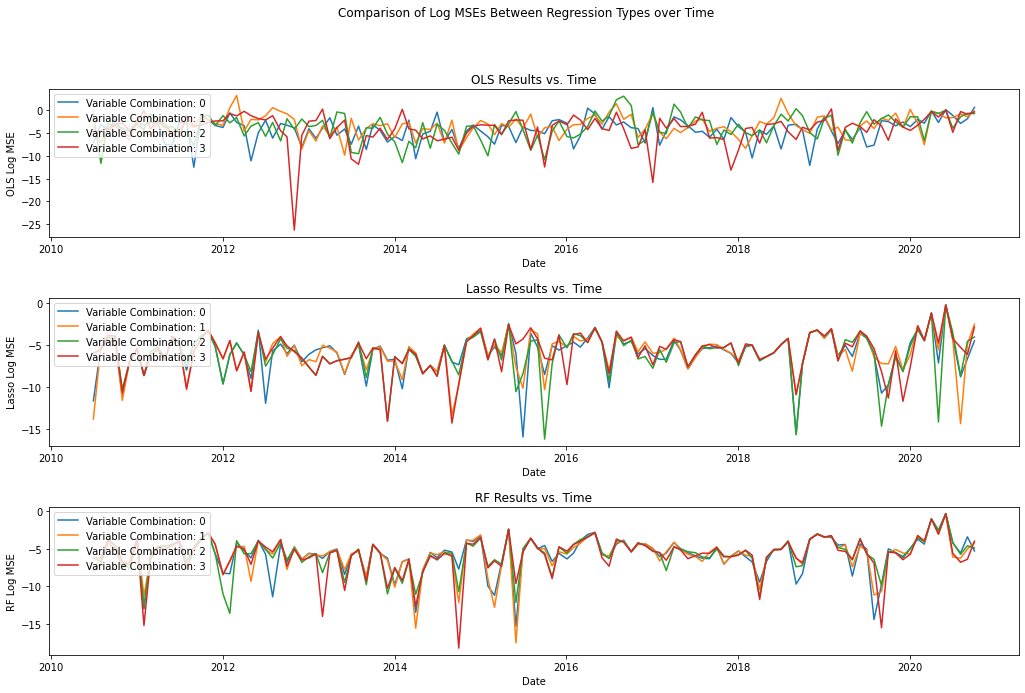

In [220]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, figsize = (15,10))
ax_counter = 0 
fig.suptitle('Comparison of Log MSEs Between Regression Types over Time')
fig.tight_layout(pad = 4.0)
for r_type in outcomes['R Type'].unique(): 
    unique_df = outcomes.loc[(outcomes['R Type'] == r_type)]
    
    for var_combo in unique_df['Var Combo'].unique(): 
        u_unique_df = unique_df.loc[(unique_df['Var Combo'] == var_combo)]
        
        ax[ax_counter].plot(u_unique_df['Date'], np.log(u_unique_df['Result']), \
                            label = 'Variable Combination: ' + str(var_combo))
        
    ax[ax_counter].legend(loc = 'upper left')
    ax[ax_counter].set_xlabel('Date')
    ax[ax_counter].set_ylabel(r_type + ' Log MSE')
    ax[ax_counter].set_title(r_type + ' Results vs. Time')
    
    ax_counter += 1

As we can see above, the weighted OLS is not very good and is subject to one very, very large harmful swing. We also see that it is unclear between Lasso and RF which is better and which of four variable combinations is the best. We print more detailed statistics below. 

In [221]:
rtype_lst = []
var_combo_lst = []
max_lst = []
min_lst = []
std_lst = []
mean_lst = []
med_lst = []
skew_lst = []
kurt_lst = []

for r_type in outcomes['R Type'].unique(): 
    unique_df = outcomes.loc[(outcomes['R Type'] == r_type)]
    
    for var_combo in unique_df['Var Combo'].unique(): 
        u_unique_df = unique_df.loc[(unique_df['Var Combo'] == var_combo)]
        value = u_unique_df['Result']
        
        rtype_lst.append(r_type)
        var_combo_lst.append(var_combo)
        max_lst.append(value.max())
        min_lst.append(value.min())
        std_lst.append(value.std())
        mean_lst.append(value.mean())
        med_lst.append(value.median())
        skew_lst.append(value.skew())
        kurt_lst.append(value.kurtosis())

analysis = pd.DataFrame(
{
    'RType' : rtype_lst, 
    'Var Combo' : var_combo_lst,
    'Max' : max_lst, 
    'Min' : min_lst, 
    'STD' : std_lst,
    'Mean' : mean_lst, 
    'Median' : med_lst, 
    'Skew' : skew_lst, 
    'Kurtosis' : kurt_lst
}
)

analysis.set_index(['RType', 'Var Combo'], inplace=True)

print('Table of Descriptive Statistics for MSEs')
analysis

Table of Descriptive Statistics for MSEs


Max           Min       STD      Mean    Median  \
RType Var Combo                                                          
OLS   0           1.638832  3.644034e-06  0.265588  0.099571  0.018377   
      1          21.686094  4.999051e-05  2.221401  0.424212  0.030313   
      2          18.869799  8.500447e-06  1.882793  0.391269  0.028204   
      3           1.175131  4.087070e-12  0.240277  0.120698  0.025130   
Lasso 0           0.798575  1.145409e-07  0.076136  0.016368  0.003746   
      1           0.780026  5.577305e-07  0.074678  0.017644  0.003956   
      2           0.749948  8.897507e-08  0.072164  0.016723  0.003877   
      3           0.736564  5.972736e-07  0.071046  0.017831  0.004460   
RF    0           0.719503  2.301581e-07  0.072436  0.018585  0.004391   
      1           0.689186  2.510976e-08  0.069721  0.017814  0.004529   
      2           0.714429  1.261385e-06  0.071283  0.018132  0.004004   
      3           0.699776  1.263438e-08  0.069893  0.017613  0.004040   

                     Skew   Kurtosis  
RType Var Combo                       
OLS   0          4.411442  20.416638  
      1          8.337682  74.195708  
      2          8.540618  79.317740  
      3          2.885378   8.067269  
Lasso 0          9.348768  93.476075  
      1          9.177494  91.068051  
      2          9.126751  89.707839  
      3          9.003774  88.082150  
RF    0          8.373771  76.078702  
      1          8.342767  75.163931  
      2          8.502338  78.403158  
      3          8.507057  78.314391

From the table above, we can safely rule out any of the OLS combinations as they have very high, maximum MSEs, STDs, and Means. From there, we can also see that Random Forest is slightly worse than Lasso, they have very similar performance in terms of mean, and it does seem that the RF is slightly better than Lasso when it comes to the mean measurement, however, Lasso has significantly smaller STDs compared to RF. I am thus choosing to optimize for consistency over sheer performance, and I have selected to use Lasso. 

Within Lasso, Lasso 0 (which represents only using Currency data) has the best performance as measured by mean and has a standard deviation which is in the middle of Lasso's range and lower than all of the RF STDs. In all of the Lasso cases, we do have that there is very high kurtosis and skew as well which makes sense because this is mean squared error with huge periodic errors, means around 0, and no values below 0 in the data set. 

We then plot everything expect OLS again below, but we see that it is (i) difficult to parse from the graph which is the best, and (ii) therefore conclude that the analysis above is sufficient to select **Lasso 0**. Unfortunately, we see that despite my best efforts to collect alternative data, our strategy is better off without using any of the data besides the currency price returns.

No handles with labels found to put in legend.


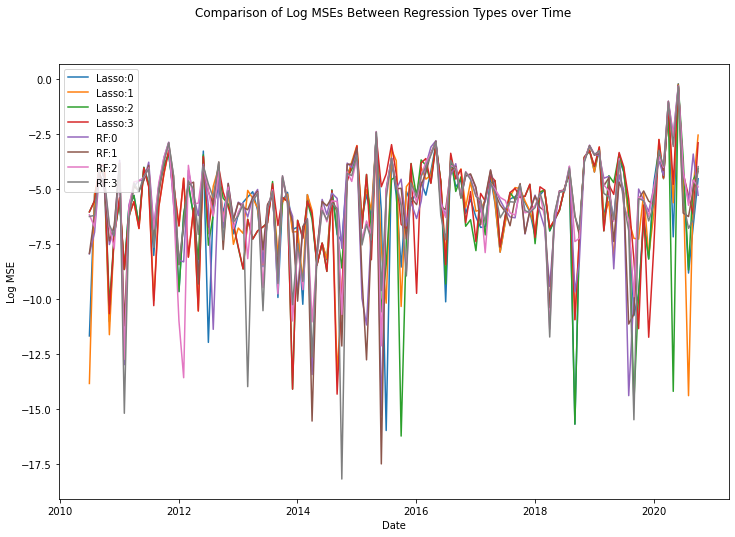

In [225]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize = (12,8))
ax_counter = 0 
fig.suptitle('Comparison of Log MSEs Between Regression Types over Time')

for r_type in outcomes['R Type'].unique():
    
    if r_type != 'OLS': 
        unique_df = outcomes.loc[(outcomes['R Type'] == r_type)]
    
        for var_combo in unique_df['Var Combo'].unique(): 
            u_unique_df = unique_df.loc[(unique_df['Var Combo'] == var_combo)]

            ax.plot(u_unique_df['Date'], np.log(u_unique_df['Result']), \
                                label = r_type + ':' + str(var_combo))
        
    ax.legend(loc = 'upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Log MSE')
    
    
    

# 7 Developing Backtest

Now that we have concluded which of the variable combinations and regression techniques to use, we will begin to build the backtest. We will assume trading costs of 0.01\%, we will assume that we have 20MM USD and are going to borrow another 80MM USD - 4:1 leverage (as per the requirements of the assignment). NB: futures contracts have leverage built in, but I still figured that this is a reasonable assumption to make about leverage overall. We will assume a 2\% borrowing cost for this capital which will be constant throughout the period. 

## 7.1 Issues with Lasso 

Now that we have determined the best combination, we will let the linear_model figure out the relationship between the currencies and the returns and then trade based on the confidence at any given period. We explore this relationship below: 

In [273]:
#alpha = 0.1 is our default Lasso given high levels of multicolinearity with this type of data 

full= []
for i_int in range(0, len(monthly_panel) - 13): 

    X, y = monthly_panel[var_combos[0]].iloc[i_int:i_int + 13], \
            monthly_panel['f_r_oil_price'].iloc[i_int:i_int + 13]
    
    training_X, testing_X = X.iloc[:-1], X.iloc[-1:]
    training_y, testing_y = y.iloc[:-1], y.iloc[-1:]

    regr = linear_model.Lasso(alpha = 0.1)
    regr.fit(training_X, training_y)
    pred_y = regr.predict(testing_X)
    full.append(regr.coef_)



In [274]:
print('Table of Used Features in Lasso and Their Parameters')
pd.DataFrame(full, columns = var_combos[0]).replace(0, np.nan).dropna(axis = 0, how='all').head()

Table of Used Features in Lasso and Their Parameters


,r_USD_AUD,r_USD_BRL,r_USD_CAD,r_USD_COP,r_USD_NOK,r_USD_MXN,r_USD_JPY,r_USD_KRW,r_USD_EUR


Now, we run into an interesting error. Despite the fact that Lasso 0 had the best performance of all of the previous tests, when we run the entire time period again and generate coefficient weights, and then drop currencies for which we never incorporate into the model, we find that we are left with 0 pairs. In essence, the regression is only using the $\alpha$ coefficient from the multivariate regression to predict $y$. This is not the aim of our research. In order to get that not all coefficients are always $0$ we have to significantly lower the $\alpha$ parameter to be much closer to 0. This reduces the Lasso to be very close in practice to OLS. 

## 7.2 Alternative Selection of Random Forest

Further, because the assignment has specified that we need to trade at least 5 distinct assets, we will now elect to continue with only Random Forest. We will use **Random Forest parameter set 3** since this has the best performance of all four Random Forests. 

We verify that RF incorporates all features below:

In [267]:
#to store the outputs
full = []

for i_int in range(0, len(monthly_panel) - 13): 

    X, y = monthly_panel[var_combos[3]].iloc[i_int:i_int + 13], \
        monthly_panel['f_r_oil_price'].iloc[i_int:i_int+13]
    
    training_X, testing_X = X.iloc[:-1], X.iloc[-1:]
    training_y, testing_y = y.iloc[:-1], y.iloc[-1:]
    
    #these are our default parameters for RF
    #we set random_state to be 42 in order to get the same results everytime 
    #we also set n_estimators to 1000 which is 10* greater than 100, computationally costly 
    #but gives us better performance 
    
    regr = ensemble.RandomForestRegressor(n_estimators = 1000, random_state = 42)    
    regr.fit(training_X, training_y)
    pred_y = regr.predict(testing_X)
    full.append(regr.feature_importances_)


In [268]:
#and now we can look and see that it used all of the pairs
importance_data = pd.DataFrame(full, columns = var_combos[3])

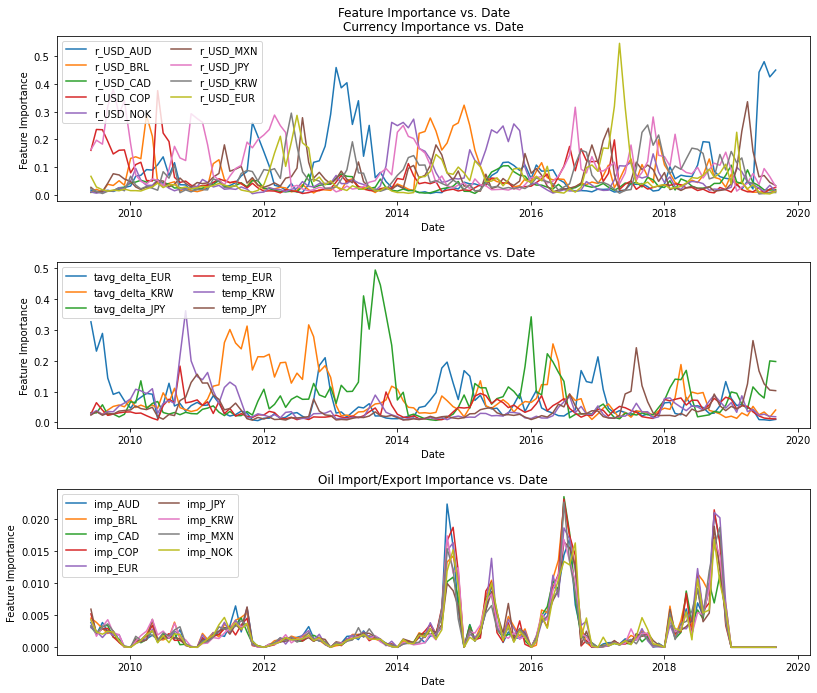

In [272]:
fig, ax = plt.subplots(3, figsize=(12,10))
fig.tight_layout(pad = 4.0 )
index = monthly_panel.iloc[0:len(monthly_panel) - 13].index
fig.suptitle('Feature Importance vs. Date \n ')
for column in importance_data.columns:
    split = column.split('_')[0]
    if split == 'r': 
        cord = 0
    if split == 'tavg' or split == 'temp': 
        cord = 1
    if split == 'imp': 
        cord = 2
    
    ax[cord].plot(index, importance_data[column], label = column)
    ax[cord].legend(loc = 'upper left', ncol = 2)
    ax[cord].set_xlabel('Date')
    ax[cord].set_ylabel('Feature Importance')
    
ax[0].set_title('Currency Importance vs. Date')    
ax[1].set_title('Temperature Importance vs. Date')  
ax[2].set_title('Oil Import/Export Importance vs. Date');  

We see above that RF consistently incorporates all of the data, weights currency returns most important, then changes in weather, then temperatures (likely a proxy for seasonal effects in oil markets), and then the World Bank oil import/export importance to a country. 

Given that we have all of the data and we know what features we are going to include in our model, and which SKLearn model we are going to use we implement our backtest finally. 

# 8 Implementing Backtest

The backtest does a couple of basic things, first, it initializes a set of variables which store information that we'll need, then for each month it takes the 12 months prior and attempts to use a RF with all four data sets (currency price returns, contemporaneous weather, the changes in the weather, and import/export importance) to predict the future month's oil movements. 

## 8.1 Risk Precautions 

Based on this prediction (how sure the algorithm is) we allocate up to 50% of our portfolio or 50% of 2x our original starting balance (as a risk precaution) to a one-month long directional oil futures trade. If the RF algorithm predicts a move of 10% +/- we invest the full 50% of our portfolio or 50% of 2x our original capital allocation whichever is smaller. With the remaining capital, we invest it in currencies according to the following rules. We split the portion of the portfolio left over after investing in oil in currencies. Of this part, we determine which currencies to invest in depending on their importance in the most recent RF model. RF has an attribute called feature importance which we then scale to determine the importance of each currency. We then either invest the remainder of our portfolio times the currency's weighting for this month or at most 1/9th of 50% of 2x our original starting balance as a risk precaution.  

## 8.2 Correlations Between Assets

We go long or short in the following manner depending on the RFs prediction for the next month's oil futures contract return:

| Nearest Month Oil Future | Export Currencies (Expressed as USD/Cur) | Import Currencies (Expressed as USD/Cur) |
| - | :-: | :-: |
| Long | Long | Short|
| Short | Short | Long|

We determined these correlations through a variety of tests. First, we tried to let OLS and Lasso give different correlations for each currency for each month based on the previous 12 months, then we tried using the opposite of the above chart and finally elected to use the above based on the stability of its performance. 

## 8.3 Predicting Costs

An important part of our strategy is predicting borrowing and trading costs. 

### 8.3.1 Borrowing Costs

For borrowing costs, we use the [LIBOR](https://fred.stlouisfed.org/series/USDONTD156N) rate on the day which we make the trade, we assume we can borrow at LIBOR plus 75 bps and that we are borrowing 80% of the money we are trading, this implies 4:1 leverage for our hypothetical hedge fund. Please note, a risk here is that the LIBOR rate could move substantially throughout the monthly period and we could be borrowing in real life with floating rates. Given the lack of large inter-month prices movements historically, I have elected to just use the first day of the month's rate for the entire month, but in reality this is a risk. Although in reality often it costs more to borrow to short than it does to long, we assume that we can borrow at the same rate for both. 

### 8.3.2 Trading Costs
We are going to use 0.01% as our transaction cost for both oil futures and currency pairs. We also assume that we liquidate every position at the end of every month before opening a new position, this will of course result in much higher transactions costs than we would experience in reality, but it is a good thing to be overly liberal with these estimates.


## 8.4 Run Backtest

Our strategy will go as follows. First, we will try to predict the next month's returns on oil given the past year's worth of data. Based on how confident we are in our results, we will invest up to 50% of our portfolio, but no more than 50% 2x our original capital (as a risk control) in oil. With our remaining money, we will invest in currencies going long the USD/import currencies when we are predicting a rise and short the USD/export currencies (vice versa in bear oil predictions). We will invest in each currency according to the RF feature selection weighting. Our risk here is also capped by the 2x our original capital minus whatever oil investment we are making for the period.

In [51]:
#get LIBOR data, from FED 
LIBOR = lib.get_LIBOR()

In [88]:
###### THIS CELL CONTAINS ALL THE BACKTESTING LOGIC ####
# I left this here instead of the lib document because I thought it 
# would be useful to review for other quants 

################## SET DEFAULTS ###############
#set trading costs
oil_tc, curr_tc = 0.001, 0.001

#we first initalize lists to store later data
#start with 100M USD 
capital_lst = [100000000]

#to recording borrowing and transaction costs 
bc_lst = [0]
tc_lst = [0]

#to record our oil predictions 
oil_preds = [0]

#to record our holdings in USD 
asset_lsts = {
    'OIL' : [0], 'AUD' : [0], 'BRL' : [0], 'CAD' : [0], 'COP' : [0],
    'EUR' : [0], 'JPY' : [0], 'KRW' : [0], 'MXN' : [0], 'NOK' : [0], 
}

#to record our PNL 
PnL_lsts = {
    'OIL' : [0], 'AUD' : [0], 'BRL' : [0], 'CAD' : [0],'COP' : [0],
    'EUR' : [0], 'JPY' : [0], 'KRW' : [0], 'MXN' : [0], 'NOK' : [0], 
}

#to record the date 
date_lst = [monthly_panel.index[12]]

#we set correlation directions between currencies and oil
#this was found through experimentation it works best to just keep 
#these values fixed in this position
correlation_directions = {
    'AUD' : 1, 'BRL' : 1, 'CAD' : 1, 'COP' : 1, 'NOK' : 1, 'MXN' : 1, 
    'KRW' : -1, 'EUR' : -1,'JPY' : -1
}

################################# TRADING LOGIC BEGINS HERE ############################

#for each date in our range 
for i_int in range(13, len(monthly_panel)): 

    ############ DETERMINE PnL FROM LAST MONTH AND SELLING COSTS ##############
    #save the date
    date = monthly_panel.index[i_int]
    date_lst.append(date)
    
    #update our capital on hand based on what happened 
    capital_on_hand = capital_lst[-1]
    
    #assume that we are financing 80% of it at LIBOR plus 75bps
    #multiply by 1/12 since we are only holding for a month 
    bc = capital_on_hand * 0.8 * LIBOR.loc[date]['LIBOR'] * (1/12) 
    bc_lst.append(bc)
    
    #we first pay out interest on last month's borrowings
    capital_on_hand = capital_on_hand - bc
    
    selling_costs = 0
    
    for asset, value in asset_lsts.items(): 
        if asset == 'OIL': 
            PnL_lsts[asset].append(value[-1] * (monthly_panel.iloc[i_int]['r_oil_price']))
            capital_on_hand += value[-1] * (monthly_panel.iloc[i_int]['r_oil_price'])
            
            selling_costs += np.abs(value[-1] * (1 + monthly_panel.iloc[i_int]['r_oil_price']) * oil_tc)
            
        else:
            #get the change for each currency since we last bought it 
            PnL_lsts[asset].append(value[-1] * (monthly_panel.iloc[i_int]['r_USD_' + asset]))
            capital_on_hand += value[-1] * (monthly_panel.iloc[i_int]['r_USD_' + asset])
            
            selling_costs += np.abs(value[-1] * (1 + monthly_panel.iloc[i_int]['r_USD_' + asset]) * curr_tc)
            
            
    capital_on_hand = capital_on_hand - selling_costs
    
    ################# DETERMINE FUTURE OIL PRICE MOVEMENTS #################
    
    #split into training and testing data for the Random Forest
    #next period oil prediction
    X, y = monthly_panel[var_combos[3]].iloc[i_int - 13 : i_int], \
        monthly_panel['f_r_oil_price'].iloc[i_int -13 : i_int]
    
    training_X, testing_X = X.iloc[:-1], X.iloc[-1:]
    training_y, testing_y = y.iloc[:-1], y.iloc[-1:]
    
    #these are our default parameters for RF
    #we set random_state to be 42 in order to get the same results everytime 
    #we also set n_estimators to 1000 which is 10* greater than 100, computationally costly 
    #but gives us better performance 
    
    regr = ensemble.RandomForestRegressor(n_estimators = 1000, random_state = 42)    
    regr.fit(training_X, training_y)
    
    #pred_y tells us how much oil we want to be holding, where we think the one month future 
    #returns will be from now 
    pred_y = regr.predict(testing_X)[0]
    oil_preds.append(pred_y)
    
    #################### DETERMINE PORTFOLIO WEIGHTS ###################
    
    #portfolio_weights tells us how important each currency is 
    portfolio_weights = regr.feature_importances_[0:9]
    
    #since other factors that we don't trade on are incorporated here, we 
    #reweight to only consider the portfolio weights for the currency factors 
    portfolio_weights = dict(zip(var_combos[0], portfolio_weights/sum(portfolio_weights)))
    
    target_weights = {
        'OIL' : 0, 'AUD' : 0, 'BRL' : 0, 'CAD' : 0, 'COP' : 0, 'NOK' : 0, 
        'MXN' : 0, 'KRW' : 0, 'EUR' : 0,'JPY' : 0
    }
    
    
    ############## SIMULATE INVESTING ############
    
    #intialize total trading cost to be 0 for every round 
    buying_costs = 0
    
    target_invest = 0
    
    for asset, target_weight in target_weights.items(): 
        if asset == 'OIL': 
            #pred y is our anticipation for next months returns 
            sign = np.sign(pred_y)
            
            #risk controls 
            target_weight = sign * min(np.abs(pred_y) * 7.5, 0.5)
            target_invest = (target_weight / 0.50) * capital_on_hand
            target_for_oil = target_invest * target_weight
            target_for_oil = sign * min(np.abs(target_for_oil), 200000000 / 2)
            
            #pay for buying costs
            target_for_oil = target_for_oil * (1 - oil_tc)
            buying_costs += np.abs(target_for_oil * oil_tc)
            
            #record 
            asset_lsts['OIL'].append(target_for_oil)
            
        else:
            #percentage of portfolio we will devote to currency hedges 
            #at most we will ever invest is 2x our original capital minus the portion devoted 
            #already to oil, this reduces our exposure on any one move
            if capital_on_hand > 200000000:
                capital_on_hand = 200000000
                
            for_curr = target_invest - np.abs(target_for_oil)
            
            direction = correlation_directions[asset]
            
            weight = portfolio_weights['r_USD_' + asset]
            
            this_curr = for_curr * weight
        
            #pay for buying costs
            this_cur = this_curr * (1 - curr_tc)
            buying_costs += np.abs(this_curr * curr_tc)
        
            #record
            asset_lsts[asset].append(this_curr * direction)
    
    #record total trading costs for this round 
    tc_lst.append(buying_costs + selling_costs)
        
    #calculate new capital and then store it 
    capital_on_hand = capital_on_hand - buying_costs
    capital_lst.append(capital_on_hand)
    
    #tell us when we're done with each year
    if date.month == 12:
        print('Finished', date.year)
    

Finished 2010
Finished 2011
Finished 2012
Finished 2013
Finished 2014
Finished 2015
Finished 2016
Finished 2017
Finished 2018
Finished 2019


In [89]:
#create a pd DataFrame from the backtest
full_backtest = pd.DataFrame({
    'Date' : date_lst, 
    'Total Trading Costs' : tc_lst, 
    'Total Borrowing Costs' : bc_lst, 
    'Running Capital' : capital_lst, 
    'OIL Holdings' : asset_lsts['OIL'], 
    'OIL Predictions' : oil_preds,
    'AUD Holdings' : asset_lsts['AUD'], 
    'BRL Holdings' : asset_lsts['BRL'], 
    'CAD Holdings' : asset_lsts['CAD'], 
    'COP Holdings' : asset_lsts['COP'], 
    'NOK Holdings' : asset_lsts['NOK'], 
    'MXN Holdings' : asset_lsts['MXN'], 
    'JPY Holdings' : asset_lsts['JPY'], 
    'KRW Holdings' : asset_lsts['KRW'], 
    'EUR Holdings' : asset_lsts['EUR'], 
    
    'OIL PnL' : PnL_lsts['OIL'],
    'AUD PnL' : PnL_lsts['AUD'],
    'BRL PnL' : PnL_lsts['BRL'],
    'CAD PnL' : PnL_lsts['CAD'],
    'COP PnL' : PnL_lsts['COP'],
    'NOK PnL' : PnL_lsts['NOK'],
    'MXN PnL' : PnL_lsts['MXN'],
    'JPY PnL' : PnL_lsts['JPY'],
    'KRW PnL' : PnL_lsts['KRW'],
    'EUR PnL' : PnL_lsts['EUR'],
    
}).set_index('Date')

for column in full_backtest.columns: 
    if 'PnL' in column or 'Costs' in column: 
        full_backtest[column] = full_backtest[column].cumsum()

full_backtest['Total Costs'] = full_backtest['Total Trading Costs'] + full_backtest['Total Borrowing Costs']
#save it to the local disk
full_backtest.to_csv("/Users/zachmariani/FINM/Final Project/Data/Data Saves/full_backtest.csv")

full_backtest.head()

,Total Trading Costs,Total Borrowing Costs,Running Capital,OIL Holdings,OIL Predictions,AUD Holdings,BRL Holdings,CAD Holdings,COP Holdings,NOK Holdings,MXN Holdings,JPY Holdings,KRW Holdings,EUR Holdings,OIL PnL,AUD PnL,BRL PnL,CAD PnL,COP PnL,NOK PnL,MXN PnL,JPY PnL,KRW PnL,EUR PnL,Total Costs
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2010-05-03,0.000000,0.000000,1.000000e+08,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-06-01,8951.330621,70000.000000,9.992105e+07,-3.416921e+05,-0.005516,-1.297382e+05,-9.072433e+04,-1.199876e+05,-4.359522e+05,-1.316944e+05,-4.608415e+06,1.423369e+06,1.276934e+06,3.928240e+05,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78951.330621
2010-07-01,83575.231312,139944.734069,9.973297e+07,-1.024186e+07,-0.030218,-1.729830e+06,-1.057131e+06,-1.149752e+06,-1.793230e+07,-1.139994e+06,-3.194499e+06,1.874201e+07,2.755780e+06,7.776540e+06,-4.103289e+03,582.912495,1150.142203,-1137.795376,11762.943044,257.378929,-6701.891718,-52147.303733,14139.994998,-7309.980459,223519.965381
2010-08-02,199935.912348,205768.496345,9.908549e+07,1.349707e+07,0.034805,9.337712e+05,1.537321e+06,6.168040e+05,1.628890e+07,5.144449e+05,9.339039e+05,-1.437725e+07,-9.044005e+05,-2.153297e+06,-8.313515e+05,140015.220137,34931.424991,39405.376840,766275.884929,88013.830869,89962.887620,-310563.521568,-106152.180039,-419343.849849,405704.408693
2010-09-01,322939.397675,270504.349293,9.795250e+07,2.699677e+07,0.049503,1.364070e+06,1.258106e+06,1.212511e+06,2.127626e+07,9.663620e+05,1.331104e+06,-1.629384e+07,-5.471076e+05,-1.541439e+06,-2.067391e+06,144703.855894,34551.239311,58200.467535,680494.990919,105591.305516,127853.127076,57458.211273,-117345.325493,-478168.704977,593443.746968


# 9 Analysis of Backtest Results

## 9.1 Total Portfolio Performance over Time

We see below that the portfolio did not perform well over time, it is clear that the COVID-19 pandemic significantly impacted performance at the end of the period. Before the COVID-19 pandemic, we see clearly a very poor Sharpe ratio and even at the best moments of performance a return of lower than 10%. 

Our sharpe ratio was:  -0.014678836828041547


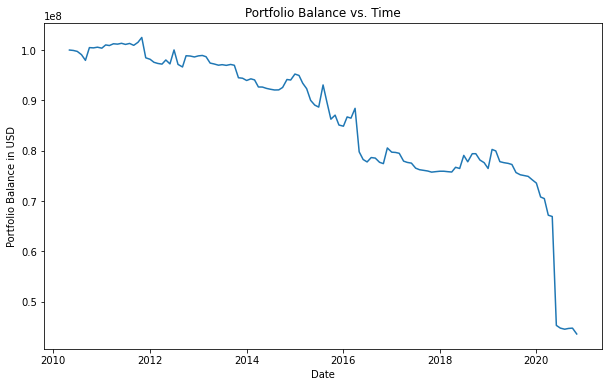

In [90]:
#plot total peformance

fig, ax = plt.subplots(figsize = (10,6))
ax.plot(full_backtest['Running Capital'])
ax.set_ylabel('Portfolio Balance in USD')
ax.set_xlabel('Date')
plt.title('Portfolio Balance vs. Time');

#https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns, sharpe if we
#assume that the RF rate is 0

r = full_backtest['Running Capital'].pct_change(1).diff()
sharpe = (r.mean() / r.std()) * np.sqrt(12)

print('Our sharpe ratio was: ', sharpe)

## 9.2 Performance by Asset

When we expand the PnL by asset, we see that the export currencies had much wider spreads than the import currencies. The academic literature had predicted this given that the export currencies should be more closely correlated with oil futures movements and thus the RF and our algorithm should devote a larger share of our portfolio to them. Further, it makes sense economically that they have a wider range of returns given that they are significantly more volatile than the import currencies (developed vs. emerging market currency volatility would imply this). Unfortunately, we see that despite the fact that at some moments we were able to make money on oil, by early 2020, we had lost a large sum on oil. This makes sense given the geopolitical demand shock at the start of COVID19. Oil market futures actually went negative for a whack moment in history and thus the RF algorithm which tries to predict month to month would have a very difficult time predicting this massive selloff given the prior year of data. 

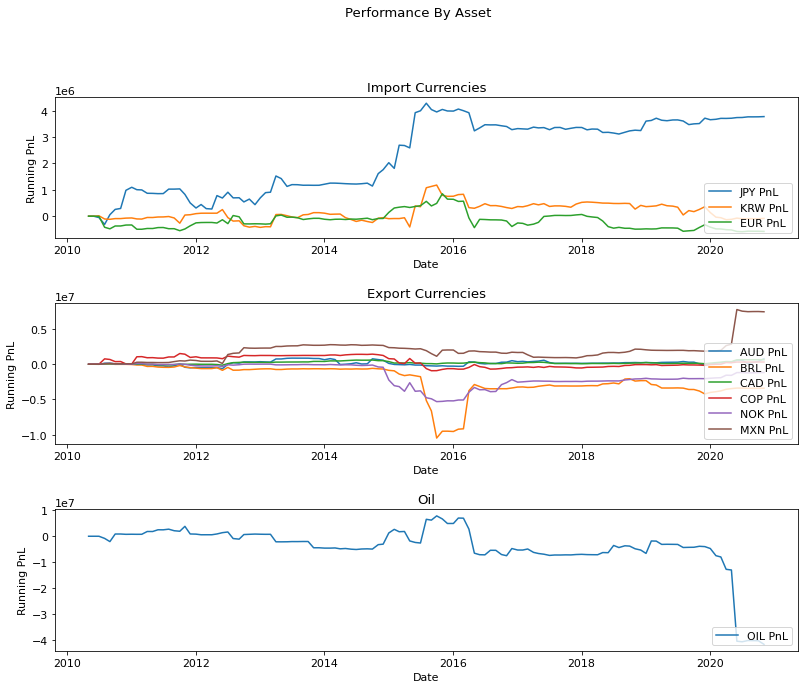

In [193]:
fig, ax = plt.subplots(3, figsize = (12,10))
fig.suptitle('Performance By Asset')
fig.tight_layout(pad = 4)

for columns in full_backtest.columns: 
    if 'PnL' in columns:
        if 'KRW' in columns or 'JPY' in columns or 'EUR' in columns:
            ax[0].plot(full_backtest[columns], label = columns)
            ax[0].legend(loc = 'lower right')
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Running PnL')
            ax[0].set_title('Import Currencies')
            
        elif 'OIL' in columns: 
            ax[2].plot(full_backtest[columns], label = columns)
            ax[2].legend(loc = 'lower right')
            ax[2].set_xlabel('Date')
            ax[2].set_ylabel('Running PnL')
            ax[2].set_title('Oil')
            
        else: 
            ax[1].plot(full_backtest[columns], label = columns)
            ax[1].legend(loc = 'lower right')
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Running PnL')
            ax[1].set_title('Export Currencies')

## Portfolio Composition Over Time

We see that for the most part our algorithm stayed on the sidelines when it was not sure about oil futures price movements, as we designed it to. We see that we had a couple of random moments where the algorithm was overly confident about the relationship between any given currency and oil prices. This is liable to happen with a RF, we can use these results in future work to see that some import/export currencies are more importantly generally than others when it comes to determining the future oil price movements. 

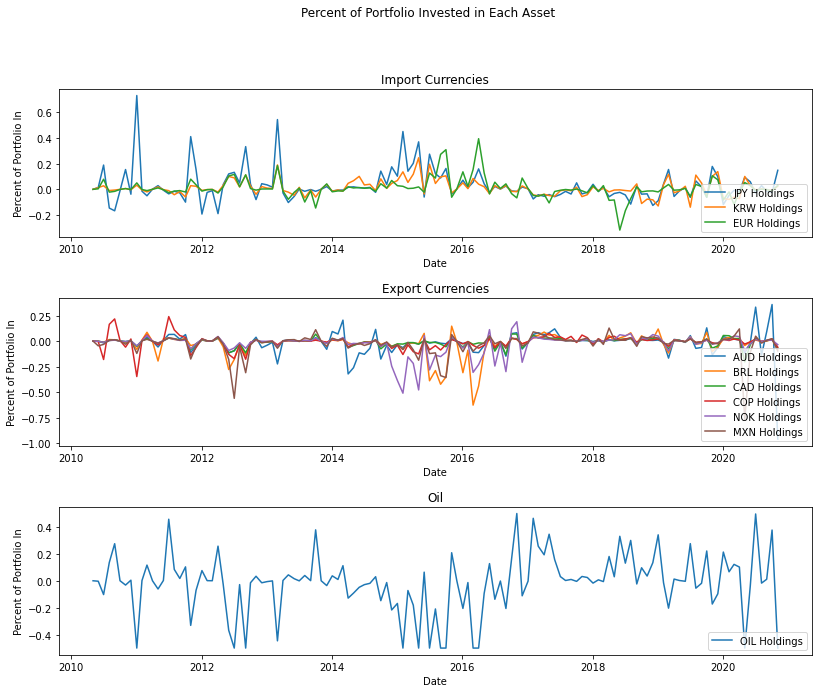

In [184]:
fig, ax = plt.subplots(3, figsize = (12,10))
fig.suptitle('Percent of Portfolio Invested in Each Asset')
fig.tight_layout(pad = 4)

for columns in full_backtest.columns: 
    if 'Holdings' in columns:
        if 'KRW' in columns or 'JPY' in columns or 'EUR' in columns:
            ax[0].plot(full_backtest[columns] / full_backtest['Running Capital'], label = columns)
            ax[0].legend(loc = 'lower right')
            ax[0].set_xlabel('Date')
            ax[0].set_ylabel('Percent of Portfolio In')
            ax[0].set_title('Import Currencies')
            
        elif 'OIL' in columns: 
            ax[2].plot(full_backtest[columns] / full_backtest['Running Capital'], label = columns)
            ax[2].legend(loc = 'lower right')
            ax[2].set_xlabel('Date')
            ax[2].set_ylabel('Percent of Portfolio In')
            ax[2].set_title('Oil')
            
        else: 
            ax[1].plot(full_backtest[columns] / full_backtest['Running Capital'], label = columns)
            ax[1].legend(loc = 'lower right')
            ax[1].set_xlabel('Date')
            ax[1].set_ylabel('Percent of Portfolio In')
            ax[1].set_title('Export Currencies')


## 9.4 Portfolio Performance vs. Assets Traded 

### 9.4.1 Oil Futures

Here is where we see why our portfolio performed so incredibly poorly towards the end of the period. Oil prices fell from roughly 80 USD a barrel to only 20 USD a barrel in one month. We had invested a considerable chunk of our portfolio in oil, as was the aim of our strategy, and a RF (nor any other predictive regression substitute) could have foreseen such a jump given this wild, unpredictable event. Even after the event had happened, the RF takes a while to adapt since it feeds in the 12 prior months of data. RF would have responded to this event better than weighted OLS or Lasso, as evidenced by our research above in the *Constructing Practical Models* section of this notebook, but nonetheless such a move was very difficult to predict and detrimental to our performance. 

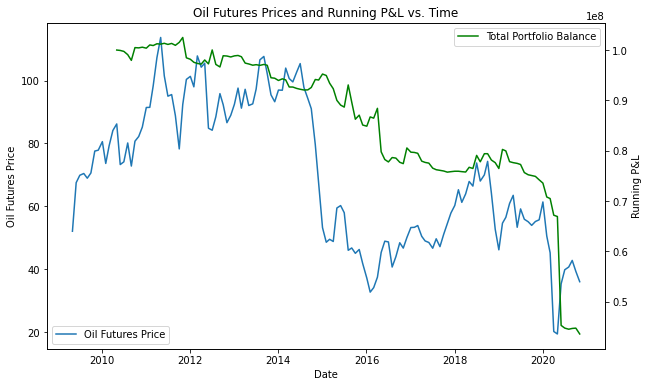

In [93]:
#plot the returns against the oil futures prices

fig,ax = plt.subplots(figsize = (10,6))
axtwin = ax.twinx()
axtwin.plot(full_backtest['Running Capital'], label = 'Total Portfolio Balance', c = 'green')



ax.plot(monthly_panel['oil_price'], label = 'Oil Futures Price')

ax.legend(loc = 'lower left')
axtwin.legend(loc = 'upper right')
ax.set_ylabel('Oil Futures Price')
ax.set_xlabel('Date')
axtwin.set_ylabel('Running P&L')
plt.title('Oil Futures Prices and Running P&L vs. Time');



### 9.4.2 Currencies 

This has been included the demonstrate currency price movements over the period.

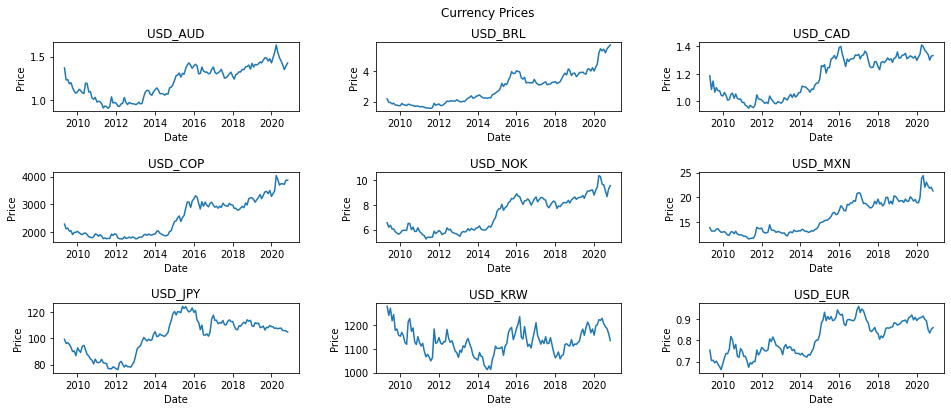

In [145]:
fig, ax = plt.subplots(3, 3, figsize = (14,6))
fig.tight_layout(pad = 4)
fig.suptitle('Currency Prices')
measures = ['USD_AUD', 'USD_BRL', 'USD_CAD', 'USD_COP', 'USD_NOK', \
                'USD_MXN', 'USD_JPY', 'USD_KRW', 'USD_EUR']

cord = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]

for n, measure in enumerate(measures): 
    counter_a, counter_b = cord[n]
    
    X = monthly_panel[measure]

    ax[counter_a, counter_b].plot(X, label = measure)
    ax[counter_a, counter_b].set_title(measure)
    ax[counter_a, counter_b].set_ylabel('Price')
    ax[counter_a, counter_b].set_xlabel('Date')
    

## 9.5 Correlations Between Individual Assets and Portfolio Returns

We see a couple of interesting things from this section. First, that there is a strong negative correlation between oil price returns and our portfolio. This is overall a good thing considering that oil prices moved much lower over the entire period and so we would like to see that our portfolio’s returns our oppositely correlated with oil. We also have that our portfolio was very correlated with returns for the USD/MXN and USD/JPY - this makes sense and follows our hypothesis that countries that import/export a lot of oil will be good at predicting the oil returns. Lastly, we see that only one currency pair USD/KRW was negatively correlated, this means that we incorrectly set the relationship parameter between the oil and USD/KRW as -1. Overall, the results here are good, we are not too closely correlated to the performance of any one asset. The assignment sheet suggests that we use a benchmark and/or discuss relationships with Fama-French factors. Given the distance between Oil, Currencies, and Equity prices, I am not going to explore correlations to Fama-French factors. Further, it makes sense that our benchmark here would be oil returns and currency returns. 

We do also see a couple of outliers in each chart, but this is to be expected. 

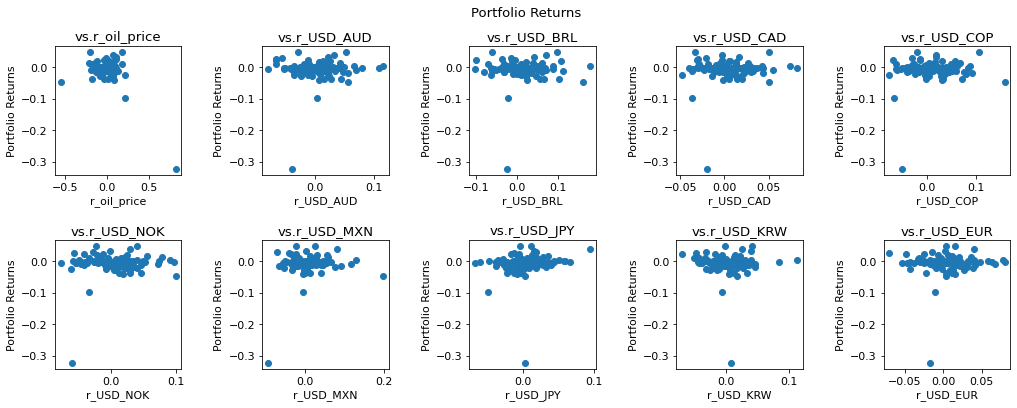

In [197]:
fig, ax = plt.subplots(2, 5, figsize = (15,6))
fig.tight_layout(pad = 4)
fig.suptitle('Portfolio Returns')
measures = ['r_oil_price', 'r_USD_AUD', 'r_USD_BRL', 'r_USD_CAD', 'r_USD_COP', \
          'r_USD_NOK', 'r_USD_MXN', 'r_USD_JPY', 'r_USD_KRW', 'r_USD_EUR']
betas = []
cord = [(0,0), (0,1), (0,2), (0,3), (0,4), (1,0), (1,1), (1,2), (1,3), (1,4)]

for n, measure in enumerate(measures): 
    counter_a, counter_b = cord[n]
    
    X = monthly_panel[measure].iloc[-126:]
    y = full_backtest['Running Capital'].pct_change(1).dropna()

    ax[counter_a, counter_b].scatter(X, y)
    ax[counter_a, counter_b].set_title('vs.' + measure)
    ax[counter_a, counter_b].set_ylabel('Portfolio Returns')
    ax[counter_a, counter_b].set_xlabel(measure)

    beta = np.cov(X,y)[0,1] / np.var(X)
    betas.append(beta)
    

In [198]:
for n, measure in enumerate(measures):
    print('There was a :', betas[n], ' correlation between ', 'portfolio returns & ', measure)

There was a : -0.13290882885931699  correlation between  portfolio returns &  r_oil_price
There was a : 0.06035898003909402  correlation between  portfolio returns &  r_USD_AUD
There was a : 0.01990191431998033  correlation between  portfolio returns &  r_USD_BRL
There was a : 0.09768273397610329  correlation between  portfolio returns &  r_USD_CAD
There was a : 0.08797112729948559  correlation between  portfolio returns &  r_USD_COP
There was a : 0.11206780227248928  correlation between  portfolio returns &  r_USD_NOK
There was a : 0.13639333119802688  correlation between  portfolio returns &  r_USD_MXN
There was a : 0.1526957354070255  correlation between  portfolio returns &  r_USD_JPY
There was a : -0.05887915592263232  correlation between  portfolio returns &  r_USD_KRW
There was a : 0.042940791445307665  correlation between  portfolio returns &  r_USD_EUR


## 9.6 Trading Costs

We see here that we pay a roughly linear trading cost over time. This implies that were are trading roughly the same volume throughout the period and we see towards the later end the derivative of the trading cost line becomes less steep as we lose more money. 

In [109]:
monthly_panel.head()

,USD_AUD,USD_BRL,USD_CAD,USD_COP,USD_NOK,USD_MXN,USD_JPY,USD_KRW,USD_EUR,oil_open,oil_high,oil_low,oil_close,oil_price,temp_EUR,prcp_EUR,temp_KRW,prcp_KRW,temp_JPY,prcp_JPY,tavg_delta_EUR,prcp_delta_EUR,tavg_delta_KRW,prcp_delta_KRW,tavg_delta_JPY,prcp_delta_JPY,imp_AUD,imp_BRL,imp_CAD,imp_COP,imp_EUR,imp_JPY,imp_KRW,imp_MXN,imp_NOK,r_USD_AUD,r_USD_BRL,r_USD_CAD,r_USD_COP,r_USD_NOK,r_USD_MXN,r_USD_JPY,r_USD_KRW,r_USD_EUR,r_oil_open,r_oil_high,r_oil_low,r_oil_close,r_oil_price,f_r_oil_open,f_r_oil_high,f_r_oil_low,f_r_oil_close,f_r_oil_price
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-05-01,1.370334,2.175265,1.185892,2293.473490,6.552357,13.814749,99.123126,1277.347879,0.753666,50.95,53.65,50.43,53.20,52.08,59.130236,0.000000,64.229772,0.0,61.233382,0.000000,4.435024,-0.072191,-2.022207,0.0,-1.806507,0.000000,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585,-0.011742,-0.008437,-0.021683,0.001438,-0.001354,0.048108,0.021632,-0.045888,-0.000991,0.026183,0.036715,0.027925,0.032008,0.029249,0.304809,0.280149,0.313306,0.289098,0.296659
2009-06-01,1.233977,1.948425,1.086714,2125.685194,6.186465,13.130690,95.951730,1239.248677,0.705118,66.48,68.68,66.23,68.58,67.53,69.017535,0.008048,72.481751,0.0,60.084349,0.428944,2.046886,-0.041239,1.392701,0.0,-1.806507,0.186146,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585,-0.099506,-0.104282,-0.083632,-0.073159,-0.055841,-0.049517,-0.031995,-0.029827,-0.064416,0.304809,0.280149,0.313306,0.289098,0.296659,0.059717,0.046156,0.034576,0.010645,0.034799
2009-07-01,1.236672,1.936320,1.148587,2151.006942,6.346569,13.121496,96.615947,1269.426059,0.706565,70.45,71.85,68.52,69.31,69.88,76.671383,0.000000,73.229772,0.0,67.310376,0.232748,3.100645,0.000000,-3.014952,0.0,0.997178,0.232748,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585,0.002184,-0.006213,0.056936,0.011912,0.025880,-0.000700,0.006922,0.024351,0.002052,0.059717,0.046156,0.034576,0.010645,0.034799,-0.016324,0.004871,0.008319,0.032751,0.008014
2009-08-03,1.188467,1.843100,1.067021,2039.038555,6.042042,13.122747,95.168989,1216.918989,0.694787,69.30,72.20,69.09,71.58,70.44,67.360637,0.024143,75.970537,0.0,71.826643,0.129493,-7.076913,0.008758,-0.681398,0.0,-5.137746,0.129493,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585,-0.038980,-0.048143,-0.071014,-0.052054,-0.047983,0.000095,-0.014976,-0.041363,-0.016669,-0.016324,0.004871,0.008319,0.032751,0.008014,0.007937,-0.011496,-0.015777,-0.049315,-0.021153
2009-09-01,1.202400,1.889995,1.100665,2055.098139,6.047345,13.515145,93.038385,1242.714889,0.702395,69.85,71.37,68.00,68.05,68.95,72.523470,0.080477,74.414908,0.0,70.453766,2.023321,4.133144,-0.044262,6.844768,0.0,-3.613014,1.659123,29.506976,8.926766,24.420644,48.300445,13.461438,27.625112,28.373379,13.278128,62.987585,0.011724,0.025444,0.031531,0.007876,0.000878,0.029902,-0.022388,0.021198,0.010950,0.007937,-0.011496,-0.015777,-0.049315,-0.021153,0.007874,0.000280,0.016618,0.040705,0.024075


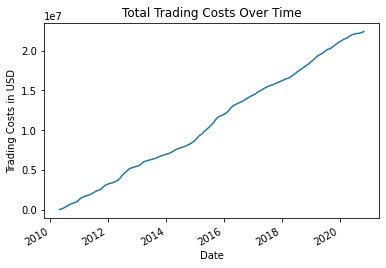

In [94]:
plt.title('Total Trading Costs Over Time')
plt.xlabel('Time')
plt.ylabel('Trading Costs in USD')
full_backtest['Total Costs'].plot();

## 9.7 Quality of Oil Futures Returns of Predictions 

This graph tells us potentially the most important takeaway from this simulation - we were not very good at predicting future oil price movements. Being able to predict them correctly 44.6% of the time is below what we would expect if we guessed with a coin flip.

It is notable that we were biased in our predictions to think that there would be a decrease when in reality there was an increase versus the opposite. I'm not exactly sure why this might happen, potentially, decreases were more likely over the entire period (drift of the oil market), so our algorithm was biased. 

In the second plot, we see that when we predict moves of greater than or equal to +/- 4%, we were correct even less of the time and had worse bias. This is not exactly what the literature would have predicted

In the third plot, we just see our predictions over time.

We correctly predicted future oil price movements  44.6 % of the time


When we were wrong:
56.83 % of the time we predicted a decrease when there was an increase
43.17 % of the time we predicted an increase when there was a decrease


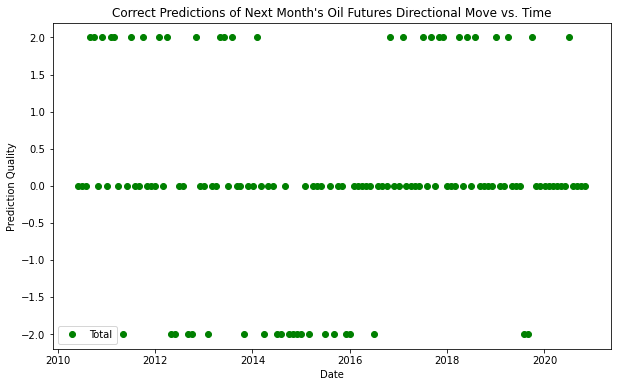

In [170]:
#plot the returns against the oil futures prices
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,6))
data = np.sign(full_backtest['OIL Predictions']) \
        + np.sign(monthly_panel['f_r_oil_price'])
                                          
#this only happens once at the start when there is no first prediction 
data = data.replace(1, np.nan).replace(-1, np.nan)
ax.plot(data , 'o', label = 'Total', c = 'green')

ax.legend(loc = 'lower left')
axtwin.legend(loc = 'upper right')
ax.set_ylabel('Prediction Quality')
ax.set_xlabel('Date')
axtwin.set_ylabel('Running P&L')
plt.title('Correct Predictions of Next Month\'s Oil Futures Directional Move vs. Time');
data = data.dropna()
pct_correct = (len(data[data!=0]) / len(data))
print('We correctly predicted future oil price movements ', round(pct_correct * 100,2) , '% of the time')

print('\n')
decrease_over_increase = round(len(data[np.sign(monthly_panel['f_r_oil_price']) == 1])*100 / len(data), 2)
increase_over_decrease = round (100 - decrease_over_increase , 2)
print('When we were wrong:')
print(decrease_over_increase, '% of the time we predicted a decrease when there was an increase')
print(increase_over_decrease, '% of the time we predicted an increase when there was a decrease')

| Predication Quality Value | Predicted Oil Futures Price Move | Actual Oil Futures Price Move |
| :--- | :--- | :--- |
| 2 | Increase | Decrease |
| 0 | Increase | Decrease |
| 0 | Decrease | Increase |
| -2 | Decrease | Decrease |

We also find that if we limit to when our predictions were of magnitude 4% or greater, we find that our accuracy was moderately worse and so was our bias.

We correctly predicted future oil price movements of magntitude >= 4%  42.5 % of the time


When we were wrong:
65.0 % of the time we predicted a decrease when there was an increase
35.0 % of the time we predicted an increase when there was a decrease


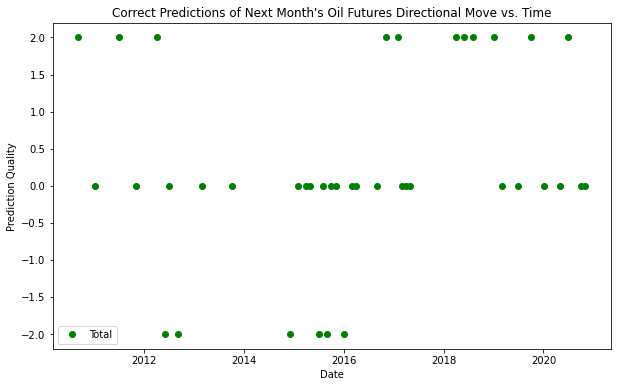

In [6]:
#plot the returns against the oil futures prices
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,6))

x = np.where(np.abs(full_backtest['OIL Predictions'])>= 0.04, full_backtest['OIL Predictions'], np.nan)

data = np.sign(x) \
        + np.sign(monthly_panel['f_r_oil_price'].iloc[-127:])
                                          
#this only happens once at the start when there is no first prediction 
data = data.replace(1, np.nan).replace(-1, np.nan)

ax.plot(data , 'o', label = 'Total', c = 'green')

ax.legend(loc = 'lower left')
# axtwin.legend(loc = 'upper right')
ax.set_ylabel('Prediction Quality')
ax.set_xlabel('Date')
# axtwin.set_ylabel('Running P&L')
plt.title('Correct Predictions of Next Month\'s Oil Futures Directional Move vs. Time');
data = data.dropna()
pct_correct = (len(data[data!=0]) / len(data))
print('We correctly predicted future oil price movements of magntitude >= 4% ', round(pct_correct * 100,2) , '% of the time')

print('\n')
decrease_over_increase = round(len(data[np.sign(monthly_panel['f_r_oil_price']) == 1])*100 / len(data), 2)
increase_over_decrease = round (100 - decrease_over_increase , 2)
print('When we were wrong:')
print(decrease_over_increase, '% of the time we predicted a decrease when there was an increase')
print(increase_over_decrease, '% of the time we predicted an increase when there was a decrease')

And a further visualization of this data over time 

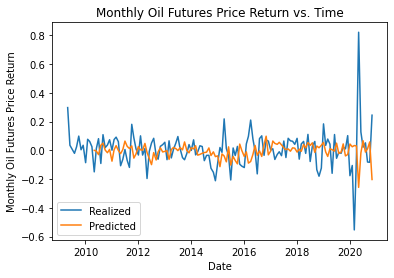

In [138]:
#plot the returns against the oil futures prices
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (10,6))

ax.plot(monthly_panel['f_r_oil_price'], label = 'Realized')
ax.plot(full_backtest['OIL Predictions'], label = 'Predicted')

ax.legend(loc = 'lower left')

ax.set_ylabel('Monthly Oil Futures Price Return')
ax.set_xlabel('Date')
plt.title('Monthly Oil Futures Price Return vs. Time');

pct_correct = (len(data[data!=0]) / len(data))


# 10 Conclusion 

## 10.1 Justification of Selections

1. Look back window, I chose monthly data because it was more computationally efficient compared to weekly data. 
2. Window, I chose based on availability of data. 
3. I chose to feed 12 months into the RF because I thought it was a reasonable period, at any given point you could always find data from just the year prior and it would include enough data without shrinking our total analysis period. 
4. I chose predicting one month returns because I felt it most closely aligned with the literature. 

## 10.2 Overview of Strategy 

This strategy attempted to use weather data, data on importance of oil as an import/export, and currency return data to predict future returns in oil futures prices. We were not able to generate any $\alpha$ and lost money. Our oil predictions were accurate 45% of the time overall and 42% of the time when making predictions of magnitude >= +/- 4%. This strategy likely failed because of the difficulties surrounding noise. It is nearly impossible to predict well future price movements given the high level of noise and human behaviors which drive the market. 


## 10.3 Potential Risks

### 10.3.1 Overall Risks 
1. Regime changes - we saw here the risk that a giant regime-change like COVID posed to such a slowly reacting algorithm. This is obviously a very strong show of support for incorporating human intuition into trading strategies. Humans would have predicted the demand shock much faster than one month into the outbreak. We didn't really see any other large regime changes in how oil and/or currencies traded. Oil moved from different levels which we did an ok job of predicting, currencies trended either in one direction or oscillated, it doesn't appear that there were large scale regime changes that would have impacted our performance there. Further, our risks to external factors (non-oil) were well hedged by our limited exposure to any given currency (as measured by correlation between returns see above).
2. Oil contract trading difficulties - for simplicity, I assumed that oil prices could be represented by a continuous current month future I found online. In practice when trading futures, you would have to worry about backwardation and contango effects as well as rollover effects. I believe that the people who assembled the continuous futures contract price assumed it was held until expiration - this is clearly not practical at all. I found some data which switched based on open interest on Quandl, but it was not accessible via my API key. Further, I assumed although maybe unrealistically that we could trade fractional shares of contracts. This is not the case, but given the size we were aiming to trade rounding to the nearest contract would not significantly affect performance.
3. Inability to decipher noise - any predictive regression type strategy struggles to predict future relationships given that this is applied psychology and not a "real" science. Our algorithm is victim to this flaw.
4. Literature $\alpha$ decay - although the literature seems clear on potential lead/lag relationships and their robustness, it was published many years ago. Since then, it is possible, even likely maybe, that quants have gotten a hold of the basic concepts in the literature and arbitraged away any possible $\alpha$ to be found from such an old and relatively basic concept.


### 10.3.2 Random Forest Risks 

1. Lag times for Random Forest predictions - by using monthly data, RF is slow to react to large prices changes. It is faster than basic OLS, but this poses a risk.
2. Inability to accurately predict currency correlations given RF - I set the correlations in a fixed dictionary, the import currencies at -1, the export currencies at 1. Unlike linear regression models (and Lasso), RF does not return correlation parameters which we could then use to determine the sign of the correlation between oil and the currency. I ran one trial using OLS to determine signs instead of the fixed correlations and updated the signs monthly, however, this had much worse, and less stable performance.  
3. The bias of our predictions - we would hope that when our predictions were wrong, they would be wrong but at least unbiased(equally likely to predict positive returns when in reality there were negative returns and vice versa). Instead, we found that there was significant bias to predicting negative returns when there in reality there are positive returns. This is something which should be explored further - I'm not sure if it's a function of the fixed *random_state* of the RF algorithm or if it's a function of the data / overall drifting down of oil prices during this period - more testing with more data is called for. 

### 10.3.3 Trading Assumptions Risks 

1. Short costs - we assumed that going long and going short would cost us the same to borrow and trade, this is unlikely in the real world.
2. We assumed fixed trading costs - this is unlikely in the real world given the long period of time and the lowering of trading costs over the past decade or so. This likely would have worked to our advantage.  
3. Liquidity, we assumed that we would never try to trade more than 200 MM USD on any given day, given the size of the oil futures market, roughly ~10B USD in open interest for contracts and given the size of the FOREX market, this seemed to me to be appropriate. I did not figure in any slippage concerns, this is unrealistic and slippage would likely affect performance. I also used the average of the open and close prices for the one month front oil contract.

## 10.4 Summary of Results 

Our trading was not very good. The way that the algorithm took on risk and managed positions lost any $\alpha$ edge we could have had from our high quality predictions. I think that this is mainly attributable to the position sizing of the oil positions. We took the next month's oil prediction and then scaled it by 7.5, we then took capped the potential portfolio trade size to 50% of our portfolio. Most of the time, our predictions for oil prices was right around 0, and as we can see above, we did not invest a great deal of our portfolio into oil. While designing the strategy, I assumed it would be better to put more weight on larger predictions, I also experimented with other weights, this had little effect.

## 10.5 Future Steps Discussion 

If I were to redo this again in the future / build on my current work, I would do a couple of things. 

1. I reduced the quality of the weather data by congregating the rich timeseries to a simple one-per-country timeseries. This sped up the process of the Random Forests which took quite a while to compute, but the value of RF is that it has the potential to pick the weight the city-specific timeseries much better than I could with my GDP/cap and population weighting. The logic underlying was appropriate for a simple OLS regression, but using ML methodologies like RF, it would have been more appropriate to include more features. 

2. I would have used weekly data instead of monthly data. I did have weekly data earlier, but it was very computationally costly to use it. I anticipate that weekly data would be better at reacting to large swings in one direction or the other. 

3. I would try to incorporate different types of data into the model, adding more and different types of data is better than any fancy RF or regression techniques. 

4. Given that my predictions were all biased, I would explore the bias in these predictions. If I were able to correct it, potentially I could address the poor performance and hopefully improve my strategy to be correct more than 50% of the time. We found that at more extreme predictions, bias was worse. At some threshold, potentially, if we correct the bias, we might be more than 50% correct. May at say 6% we could have 42% correct predictions with 70/30 bias. Then, by correcting this bias, we would see an overall improvement of 20% * 58% = 11.6% improvement in prediction which would put us above the 50% threshold. This is speculative, but I did want to share some good news from this round of research. 